# Importing Line

In [ ]:

import numpy as np
import pandas as pd
from pathlib import Path
import gc


# xsuite
import xtrack as xt
import xmask as xm
import xfields as xf
import xpart as xp


# BBStudies
import sys
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies')
sys.path.append('/home/phbelang/abp/BBStudies')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as tune
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Base as phys
import BBStudies.Physics.Constants as cst


# JOB imports
import importlib
sys.path.append('../../')
main_002 = importlib.import_module('Jobs.002_user_specific_tasks.main')
user_specific_tasks = main_002.user_specific_tasks



# Load collider and install collimators
# collider = user_specific_tasks( config_path       = "../002_user_specific_tasks/config.yaml",
#                                 collider_path     = "../001_configure_collider/zfruits/collider_001.json",
#                                 collider_out_path = None,
#                                 collider          = None)

collider = xt.Multiline.from_json('../001_configure_collider/zfruits/collider_001.json')

# Choosing context for multithreading
#--------------------------------------
import xobjects as xo
# context = xo.ContextCpu(omp_num_threads='auto')
context = xo.ContextCupy()
collider.build_trackers(_context=context)
#--------------------------------------

twiss_full = {}
twiss_full['lhcb1'] = collider['lhcb1'].twiss().to_pandas()
twiss_full['lhcb2'] = collider['lhcb2'].twiss().reverse().to_pandas()

# Filtering twiss to get rid of slices
twiss = {}
for sequence in ['lhcb1','lhcb2']:
    twiss[sequence] = xPlus.filter_twiss(twiss_full[sequence].set_index('name'),entries=['drift','..','_entry','_exit']).reset_index()




Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


In [ ]:
len(collider['lhcb1'].elements)

80976

---
# Particle coordinates
---

In [ ]:

# ==================================================================================================
# --- Functions to read configuration files and generate configuration files for orbit correction
# ==================================================================================================
import ruamel.yaml
ryaml = ruamel.yaml.YAML()
def read_configuration(config_path="config.yaml"):
    # Read configuration for simulations
    with open(config_path, "r") as fid:
        config = ryaml.load(fid)


    return config

config = read_configuration('../001_configure_collider/config.yaml')

In [ ]:
emittx,emitty = (config['config_collider']['config_beambeam'][f'nemitt_{plane}'] for plane in ['x','y'])

In [ ]:
emitty

1.8e-06

In [ ]:
n_r     = int(np.floor(np.sqrt(20e3)))
n_theta = n_part//n_r  +1
n_r,n_theta,n_r*n_theta

(141, 142, 20022)

In [ ]:
momentum    = phys.polar_grid(  r_sig     = np.linspace(0,10,n_r),
                                    theta_sig = np.linspace(0,np.pi/2,n_theta))

In [ ]:
momentum.sample(frac=1)

r_sig  theta_sig     x_sig     y_sig
7989   6.642857   0.623862  5.391530  3.880587
19877  9.785714   1.559656  0.109015  9.785107
7794   2.785714   0.612722  2.278953  1.602054
5466   7.714286   0.423335  7.033299  3.169056
11728  1.785714   0.924653  1.075199  1.425736
...         ...        ...       ...       ...
14606  5.928571   1.147461  2.435478  5.405220
477    3.857143   0.033421  3.854989  0.128886
11270  9.357143   0.880092  5.961254  7.212460
13076  7.428571   1.024917  3.856692  6.348984
6921   0.857143   0.545880  0.732575  0.445003

[20022 rows x 4 columns]

In [ ]:

ID

[15762,
 12031,
 9440,
 15565,
 10698,
 9111,
 13748,
 13329,
 5667,
 16773,
 19482,
 14644,
 15217,
 4902,
 16506,
 2433,
 7278,
 17464,
 11780,
 18672,
 3359,
 5565,
 290,
 8819,
 11813,
 9787,
 10314,
 6748,
 17801,
 6380,
 11149,
 4654,
 8000,
 15321,
 11247,
 12769,
 7919,
 12965,
 13076,
 17157,
 14608,
 11649,
 19066,
 6638,
 6718,
 5520,
 14480,
 19696,
 9984,
 6961,
 8056,
 311,
 14140,
 4341,
 2790,
 12945,
 14612,
 17886,
 7654,
 11154,
 15399,
 8140,
 5704,
 14993,
 9924,
 3492,
 3931,
 5634,
 13734,
 10242,
 18293,
 5788,
 9721,
 9746,
 11157,
 19229,
 3130,
 3293,
 15745,
 2963,
 2646,
 19217,
 2694,
 7445,
 3231,
 8480,
 978,
 1029,
 17175,
 10700,
 12678,
 12804,
 15944,
 339,
 5393,
 3330,
 3738,
 18491,
 9487,
 3152,
 19688,
 9625,
 3957,
 18556,
 4999,
 19320,
 1857,
 17105,
 3837,
 15407,
 4380,
 7120,
 7206,
 1332,
 14609,
 9187,
 10927,
 7542,
 17536,
 17518,
 12706,
 14681,
 7059,
 14397,
 1395,
 13285,
 11406,
 1130,
 12709,
 18055,
 19841,
 2097,
 2682,
 3922,


In [ ]:
momentum    = phys.polar_grid(  r_sig     = np.linspace(0,10,n_r),
                                    theta_sig = np.linspace(0,np.pi/2,n_theta))

# Shuffling momentum
#-----------------------
ID = list(momentum.index)
np.random.shuffle(ID)
momentum = momentum.loc[ID,['x_sig','y_sig']].reset_index(drop=True).rename(columns={'x_sig':'px_sig','y_sig':'py_sig'})
#-----------------------

momentum

px_sig    py_sig
0      0.336273  0.630178
1      0.829858  1.897933
2      0.326420  1.095250
3      8.466406  4.763121
4      9.213714  0.102649
...         ...       ...
20017  0.706664  0.485098
20018  4.058577  5.258850
20019  8.308682  5.435286
20020  4.914160  8.296730
20021  0.938076  6.431952

[20022 rows x 2 columns]

(-0.5, 10.5, -0.5, 10.5)

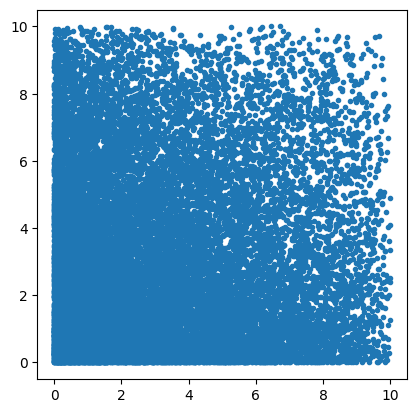

In [ ]:




def generate_particles(n_part = 1000,force_n_part = False,line = None,_context = None):
    # Generating Coord grid
    #=========================================================
    nemitt_x,nemitt_y = (config['config_collider']['config_beambeam'][f'nemitt_{plane}'] for plane in ['x','y'])

    n_part  = int(n_part)
    n_r     = int(np.floor(np.sqrt(n_part)))
    n_theta = int(n_part//n_r + 1)
    coordinates = phys.polar_grid(  r_sig     = np.linspace(0,10,n_r),
                                    theta_sig = np.linspace(0,np.pi/2,n_theta))
    
    momentum  = phys.polar_grid(  r_sig     = np.linspace(0,10,n_r),
                                    theta_sig = np.linspace(0,np.pi/2,n_theta))
    
    # Shuffling momentum
    #-----------------------
    ID = list(momentum.index)
    np.random.shuffle(ID)
    momentum = momentum.loc[ID,['x_sig','y_sig']].reset_index(drop=True).rename(columns={'x_sig':'px_sig','y_sig':'py_sig'})
    #-----------------------

    coordinates = pd.concat([coordinates,momentum],axis=1)
    # coordinates.insert(0,'delta',0)
    

    if force_n_part:
        coordinates = coordinates[:n_part]

    if line is not None:
        particles = xp.build_particles(  line   = line,
                                        x_norm  =coordinates.x_sig.values,
                                        px_norm =coordinates.px_sig.values,
                                        y_norm  =coordinates.y_sig.values,
                                        py_norm =coordinates.py_sig.values,
                                        nemitt_x=nemitt_x, nemitt_y=nemitt_y,
                                        _context=_context)
    else:
        particles = None


    
    return particles,coordinates



particles,coordinates = generate_particles(20e3,line=collider[seq],force_n_part=True)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(coordinates.x_sig,coordinates.px_sig,'.')
plt.axis('square')

# Tracking test

In [ ]:
particles

Particles(_capacity=20000, _num_active_particles=-1, _num_lost_particles=-1, start_tracking_at_element=-1, q0=1.0, mass0=938272088.16, _p0c=[6.79999994e+12 6.79999994e+12 6.79999994e+12 ... 6.79999994e+12
 6.79999994e+12 6.79999994e+12], _gamma0=[7247.36468857 7247.36468857 7247.36468857 ... 7247.36468857 7247.36468857
 7247.36468857], _beta0=[0.99999999 0.99999999 0.99999999 ... 0.99999999 0.99999999 0.99999999], s=[0. 0. 0. ... 0. 0. 0.], zeta=[ 6.71560634e-07  1.60173423e-06  1.58475658e-06 ...  1.81487475e-06
 -5.74259026e-07  1.52243177e-06], _ptau=[1.02847662e-06 1.02854912e-06 1.02828993e-06 ... 1.02918583e-06
 1.02879444e-06 1.02899108e-06], _delta=[1.02847663e-06 1.02854913e-06 1.02828993e-06 ... 1.02918584e-06
 1.02879445e-06 1.02899109e-06], _rpp=[0.99999897 0.99999897 0.99999897 ... 0.99999897 0.99999897 0.99999897], _rvv=[1. 1. 1. ... 1. 1. 1.], chi=[1. 1. 1. ... 1. 1. 1.], charge_ratio=[1. 1. 1. ... 1. 1. 1.], weight=[0. 0. 0. ... 0. 0. 0.], particle_id=[    0     1     2

In [ ]:
# Reloading xPlus
xPlus = importlib.reload(xPlus)
seq = 'lhcb1'

# Create initial particles

n_sigmas = 10
n_part   = int(20e3)
x_norm  = np.random.uniform(-n_sigmas, n_sigmas, n_part) 
px_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
y_norm  = np.random.uniform(-n_sigmas, n_sigmas, n_part) 
py_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
part = xp.build_particles( line = collider[seq],
                            x_norm=x_norm,
                            px_norm=px_norm,
                            y_norm=y_norm,
                            py_norm=py_norm,
                            nemitt_x=2.5e-6, nemitt_y=2.5e-6,
                            _context=context)



# num_turns = int(1e2)
# collider[seq].track(part, num_turns=num_turns,turn_by_turn_monitor=True)
# df = pd.DataFrame(collider[seq].record_last_track.to_dict()['data'])
# df.groupby('at_turn').count()

# monitor_TCP = {'tcp.d6l7.b1':xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,num_particles=n_part)}
# collider[seq].discard_tracker()
# for ee_name,monitor in monitor_TCP.items():
#     monitor.allow_backtrack=False
#     collider[seq].insert_element(index=ee_name, element=monitor, name=ee_name+'_monitor')
# collider[seq].build_tracker(_context=context)





# # Tracking
tracked = xPlus.Tracking_Interface( line      = collider[seq],
                                    particles = part,
                                    n_turns   = 1000,
                                    method    ='6D',
                                    skip_extraction = False,
                                    progress  = False,
                                    saveVars  = False,
                                    rebuild   = True,
                                    monitor   = None,
                                    context   = context)




# tracked = xPlus.Tracking_Interface(collider[seq],particles=part,n_turns = 100,method='4d',progress=True,saveVars = False)

# _tracked = xPlus.Tracking_Interface(collider[seq],particles=part,n_turns = 100,method='6D',progress=False,saveVars = False)
# _tracked.df.groupby('at_turn').count()
# tracked.df.groupby('turn').count()
# tracked.df.groupby('at_element').count()


Output()

In [ ]:
import rich

In [ ]:
rich.inspect(tracked)

/home/phbelang/abp/BBStudies/Executables/miniforge3/envs/py-BB/lib/python3.10/site-packages/PyNAFF/PyNAFF.py:250: UserWarning: ## PyNAFF::naff: Remove the DC component from the data (i.e. the mean).
  warn('## PyNAFF::naff: Remove the DC component from the data (i.e. the mean).')


╭─────────────────── <class 'BBStudies.Tracking.XsuitePlus.Tracking_Interface'> ───────────────────╮
│ ╭──────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <BBStudies.Tracking.XsuitePlus.Tracking_Interface object at 0x7fdde10d0280>                  │ │
│ ╰──────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                  │
│         context = <xobjects.context_cupy.ContextCupy object at 0x7fdf784a4fa0>                   │
│     coordinates =                  x            px         y        py      zeta     pzeta  \    │
│                   particle                                                                       │
│                   0         0.001248 -2.489211e-05 -0.000162 -0.000001  0.000023  0.000001       │
│                   1        -0.000639  1.281439e-05 -0.001290 -0.000015 -0.000010  0.000001       │
│                   2        -0.000179  3.010308e-06 -0.001189 -0.000013 -0.000002  0.000001       │
│                   3        -0.000044 -1.975754e-07  0.002099  0.000024  0.000001  0.000001       │
│                   4        -0.000042 -4.252258e-07  0.001937  0.000024  0.000001  0.000001       │
│                   ...            ...           ...       ...       ...       ...       ...       │
│                   19995     0.001466 -2.989491e-05  0.001391  0.000017  0.000027  0.000001       │
│                   19996     0.001572 -3.014311e-05 -0.000741 -0.000009  0.000028  0.000001       │
│                   19997    -0.000685  1.536657e-05 -0.002265 -0.000027 -0.000012  0.000001       │
│                   19998    -0.001105  2.164569e-05  0.001049  0.000013 -0.000018  0.000001       │
│                   19999    -0.001817  3.363008e-05  0.001567  0.000019 -0.000029  0.000001       │
│                                                                                                  │
│                                 ptau  beta0                                                      │
│                   particle                                                                       │
│                   0         0.000001    1.0                                                      │
│                   1         0.000001    1.0                                                      │
│                   2         0.000001    1.0                                                      │
│                   3         0.000001    1.0                                                      │
│                   4         0.000001    1.0                                                      │
│                   ...            ...    ...                                                      │
│                   19995     0.000001    1.0                                                      │
│                   19996     0.000001    1.0                                                      │
│                   19997     0.000001    1.0                                                      │
│                   19998     0.000001    1.0                                                      │
│                   19999     0.000001    1.0                                                      │
│                                                                                                  │
│                   [20000 rows x 8 columns]                                                       │
│              df =           turn  particle         x        px         y            py  \        │
│                   0            0         0  0.001248 -0.000025 -0.000162 -1.417100e-06           │
│                   1            1         0 -0.000556  0.000002  0.000159  2.396260e-06           │
│                   2            2         0 -0.000835  0.000025  0.000115  7.072379e-07           │
│                   3            3         0  0.001268 -0.000

In [3]:
from rich.progress import Progress, BarColumn, TextColumn,TimeElapsedColumn,SpinnerColumn,TimeRemainingColumn
import time


class test_spinner():

    def __init__(self,):
        # Progress info
        #-------------------------
        self.progress  = False
        self._plive    = None
        self._pstatus  = None
        #-------------------------

        try:
            self.main_test()
        except KeyboardInterrupt:
            self.closeLiveDisplay()

    def main_test(self,):
        self.startSpinner()
        time.sleep(3)  
        self.closeLiveDisplay()


        # Progress bar methods
    #=============================================================================
    def startProgressBar(self,):
        self._plive = Progress("{task.description}",
                                TextColumn("[progress.remaining] ["),TimeRemainingColumn(),TextColumn("[progress.remaining]remaining ]   "),
                                SpinnerColumn(),
                                BarColumn(bar_width=40),
                                TextColumn("[progress.percentage]{task.percentage:>3.0f}%"),
                                TimeElapsedColumn())

        self._plive.start()
        self._plive.live._disable_redirect_io()

        self._pstatus = self._plive.add_task("[blue]Tracking\n", total=self.n_turns)
    
    def updateProgressBar(self,):
        self._plive.update(self._pstatus, advance=1,update=True)

        
    def startSpinner(self,):
        self._plive = Progress("{task.description}",
                                SpinnerColumn('aesthetic'),
                                TextColumn("[progress.elapsed] ["),TimeElapsedColumn (),TextColumn("[progress.elapsed]elapsed ]   "))

        self._plive.start()
        self._plive.live._disable_redirect_io()

        self._pstatus = self._plive.add_task("[blue]Tracking")


    def closeLiveDisplay(self,):
        self._plive.refresh()
        self._plive.stop()
        self._plive.console.clear_live()


test_spinner()

Output()

In [1]:
2+2

4

In [ ]:
part.to_pandas()

start_tracking_at_element   q0         mass0    s      zeta  chi  \
0                             -1  1.0  9.382721e+08  0.0 -0.000051  1.0   
1                             -1  1.0  9.382721e+08  0.0 -0.000065  1.0   
2                             -1  1.0  9.382721e+08  0.0 -0.000017  1.0   
3                             -1  1.0  9.382721e+08  0.0 -0.000095  1.0   
4                             -1  1.0  9.382721e+08  0.0 -0.000159  1.0   
...                          ...  ...           ...  ...       ...  ...   
19995                         -1  1.0  9.382721e+08  0.0 -0.000053  1.0   
19996                         -1  1.0  9.382721e+08  0.0 -0.000048  1.0   
19997                         -1  1.0  9.382721e+08  0.0 -0.000086  1.0   
19998                         -1  1.0  9.382721e+08  0.0 -0.000031  1.0   
19999                         -1  1.0  9.382721e+08  0.0 -0.000096  1.0   

       charge_ratio  weight  particle_id  at_element  ...         y  \
0               1.0     0.0            0           0  ...  0.002079   
1               1.0     0.0            1           0  ...  0.001031   
2               1.0     0.0            2           0  ...  0.000546   
3               1.0     0.0            3           0  ... -0.000456   
4               1.0     0.0            4           0  ... -0.001044   
...             ...     ...          ...         ...  ...       ...   
19995           1.0     0.0        19995           0  ...  0.000556   
19996           1.0     0.0        19996           0  ...  0.000776   
19997           1.0     0.0        19997           0  ...  0.000541   
19998           1.0     0.0        19998           0  ...  0.000641   
19999           1.0     0.0        19999           0  ... -0.000246   

                 px        py     delta      ptau  rvv       rpp  \
0     -6.679373e-06  0.000024  0.000001  0.000001  1.0  0.999999   
1     -6.466172e-07  0.000020  0.000001  0.000001  1.0  0.999999   
2     -1.936981e-05  0.000010  0.000001  0.000001  1.0  0.999999   
3      1.890276e-05 -0.000005  0.000001  0.000001  1.0  0.999999   
4      2.397989e-05 -0.000005  0.000001  0.000001  1.0  0.999999   
...             ...       ...       ...       ...  ...       ...   
19995 -3.426561e-05  0.000007  0.000001  0.000001  1.0  0.999999   
19996 -3.138741e-05  0.000009  0.000001  0.000001  1.0  0.999999   
19997  3.661325e-05  0.000006  0.000001  0.000001  1.0  0.999999   
19998  1.087552e-05  0.000005  0.000001  0.000001  1.0  0.999999   
19999  3.403753e-05 -0.000005  0.000001  0.000001  1.0  0.999999   

                p0c  beta0       gamma0  
0      6.800000e+12    1.0  7247.364689  
1      6.800000e+12    1.0  7247.364689  
2      6.800000e+12    1.0  7247.364689  
3      6.800000e+12    1.0  7247.364689  
4      6.800000e+12    1.0  7247.364689  
...             ...    ...          ...  
19995  6.800000e+12    1.0  7247.364689  
19996  6.800000e+12    1.0  7247.364689  
19997  6.800000e+12    1.0  7247.364689  
19998  6.800000e+12    1.0  7247.364689  
19999  6.800000e+12    1.0  7247.364689  

[20000 rows x 28 columns]

In [ ]:
n_sigmas = 10
n_part   = int(20e3)
x_norm  = np.random.uniform(-n_sigmas, n_sigmas, n_part) 
px_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
y_norm  = np.random.uniform(-n_sigmas, n_sigmas, n_part) 
py_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
part2 = xp.build_particles( line = collider[seq],
                            x_norm=x_norm,
                            px_norm=px_norm,
                            y_norm=y_norm,
                            py_norm=py_norm,
                            nemitt_x=2.5e-6, nemitt_y=2.5e-6,
                            _context=context)

In [ ]:
test = part2.to_pandas()[['x','px','y','py','zeta','ptau','beta0']].copy(deep=True)
test.insert(5,'pzeta',test['ptau']/test['beta0'])
test

x        px         y        py      zeta     pzeta      ptau  \
0     -0.001576  0.000029  0.001732  0.000020 -0.000025  0.000001  0.000001   
1     -0.000608  0.000013 -0.000846 -0.000010 -0.000010  0.000001  0.000001   
2      0.001736 -0.000033  0.001041  0.000012  0.000031  0.000001  0.000001   
3     -0.001454  0.000028  0.002582  0.000031 -0.000024  0.000001  0.000001   
4      0.001810 -0.000037  0.002425  0.000027  0.000034  0.000001  0.000001   
...         ...       ...       ...       ...       ...       ...       ...   
19995 -0.001771  0.000036 -0.000403 -0.000004 -0.000031  0.000001  0.000001   
19996 -0.000102  0.000004 -0.001962 -0.000024 -0.000002  0.000001  0.000001   
19997 -0.000332  0.000008  0.000364  0.000005 -0.000005  0.000001  0.000001   
19998  0.000826 -0.000014 -0.002175 -0.000026  0.000014  0.000001  0.000001   
19999 -0.000865  0.000015  0.002410  0.000029 -0.000013  0.000001  0.000001   

       beta0  
0        1.0  
1        1.0  
2        1.0  
3        1.0  
4        1.0  
...      ...  
19995    1.0  
19996    1.0  
19997    1.0  
19998    1.0  
19999    1.0  

[20000 rows x 8 columns]

In [ ]:
test

x        px         y        py     pzeta      zeta  \
particle                                                               
0        -0.001576  0.000029  0.001732  0.000020  0.000001 -0.000025   
1        -0.000608  0.000013 -0.000846 -0.000010  0.000001 -0.000010   
2         0.001736 -0.000033  0.001041  0.000012  0.000001  0.000031   
3        -0.001454  0.000028  0.002582  0.000031  0.000001 -0.000024   
4         0.001810 -0.000037  0.002425  0.000027  0.000001  0.000034   
...            ...       ...       ...       ...       ...       ...   
19995    -0.001771  0.000036 -0.000403 -0.000004  0.000001 -0.000031   
19996    -0.000102  0.000004 -0.001962 -0.000024  0.000001 -0.000002   
19997    -0.000332  0.000008  0.000364  0.000005  0.000001 -0.000005   
19998     0.000826 -0.000014 -0.002175 -0.000026  0.000001  0.000014   
19999    -0.000865  0.000015  0.002410  0.000029  0.000001 -0.000013   

              ptau  beta0  
particle                   
0         0.000001    1.0  
1         0.000001    1.0  
2         0.000001    1.0  
3         0.000001    1.0  
4         0.000001    1.0  
...            ...    ...  
19995     0.000001    1.0  
19996     0.000001    1.0  
19997     0.000001    1.0  
19998     0.000001    1.0  
19999     0.000001    1.0  

[20000 rows x 8 columns]

In [ ]:
test.index.name = 'particle'


In [ ]:
list(test.columns).index('zeta')

5

In [ ]:
test.insert(list(test.columns).index('zeta')+1,'pzeta',test['ptau']/test['beta0'])

In [ ]:
tracked = xPlus.Tracking_Interface( line      = collider[seq],
                                    particles = part,
                                    n_turns   = 100,
                                    method    ='6D',
                                    progress  = False,
                                    saveVars  = False,
                                    monitor   = None,
                                    context   = context,
                                    rebuild   = True)

In [ ]:
collider[seq].discard_tracker()
collider[seq].build_tracker(_context=context)

part = xp.build_particles( line = collider[seq],
                            x_norm=x_norm,
                            px_norm=px_norm,
                            y_norm=y_norm,
                            py_norm=py_norm,
                            nemitt_x=2.5e-6, nemitt_y=2.5e-6,
                            _context=context)

In [ ]:
tracked = xPlus.Tracking_Interface( line      = collider[seq],
                                    particles = part,
                                    n_turns   = 1000,
                                    method    ='6D',
                                    progress  = False,
                                    saveVars  = False,
                                    monitor   = None,
                                    context   = context)

In [ ]:



collider[seq].track(part, num_turns=10000,turn_by_turn_monitor=True)

OutOfMemoryError: Out of memory allocating 36,800,001,024 bytes (allocated so far: 8,540,710,400 bytes).

In [ ]:
monitor = xt.ParticlesMonitor( _context         = context,
                                                start_at_turn    = 0, 
                                                stop_at_turn     = n_turns,
                                                n_repetitions    = 1,
                                                repetition_period= 1,
                                                num_particles    = len(part.particle_id))

In [ ]:
collider[seq].track(part, num_turns=n_turns,
              turn_by_turn_monitor=monitor)

In [ ]:
n_turns = 100
collider[seq].track(part, num_turns=n_turns)

In [ ]:
n_turns = 1000
collider[seq].track(part, num_turns=n_turns, turn_by_turn_monitor = True)

In [ ]:
tracked.df.groupby('at_element').get_group(52215).mean()

start_tracking_at_element    0.000000e+00
q0                           0.000000e+00
mass0                        0.000000e+00
s                            1.312446e+04
zeta                         1.763349e-05
chi                          1.000000e+00
charge_ratio                 1.000000e+00
weight                       0.000000e+00
particle_id                  2.417707e+02
at_element                   5.221500e+04
at_turn                      4.574626e+01
state                        1.000000e+00
parent_particle_id           2.417707e+02
_rng_s1                      0.000000e+00
_rng_s2                      0.000000e+00
_rng_s3                      0.000000e+00
_rng_s4                      0.000000e+00
x                           -5.349802e-06
y                           -2.536602e-07
px                           1.126839e-07
py                           3.784562e-08
delta                        1.034633e-06
ptau                         1.034633e-06
rvv                          1.000

In [ ]:
tracked.df[tracked.df['beta0']>0.999].groupby('at_element').count()

start_tracking_at_element     q0  mass0      s   zeta    chi  \
at_element                                                                 
0                                  60     60     60     60     60     60   
52215                           13021  13021  13021  13021  13021  13021   

            charge_ratio  weight  particle_id  at_turn  ...      y     px  \
at_element                                              ...                 
0                     60      60           60       60  ...     60     60   
52215              13021   13021        13021    13021  ...  13021  13021   

               py  delta   ptau    rvv    rpp    p0c  beta0  gamma0  
at_element                                                           
0              60     60     60     60     60     60     60      60  
52215       13021  13021  13021  13021  13021  13021  13021   13021  

[2 rows x 27 columns]

In [ ]:
tracked.df[tracked.df['beta0']>0.999].groupby('at_element').get_group(0).mean()

start_tracking_at_element    0.000000e+00
q0                           0.000000e+00
mass0                        0.000000e+00
s                            0.000000e+00
zeta                         6.266877e-06
chi                          1.000000e+00
charge_ratio                 1.000000e+00
weight                       0.000000e+00
particle_id                  2.247000e+02
at_element                   0.000000e+00
at_turn                      5.100000e+00
state                        1.000000e+00
parent_particle_id           2.247000e+02
_rng_s1                      0.000000e+00
_rng_s2                      0.000000e+00
_rng_s3                      0.000000e+00
_rng_s4                      0.000000e+00
x                            9.871919e-05
y                            2.475171e-04
px                          -1.699404e-06
py                          -8.765246e-07
delta                        1.029203e-06
ptau                         1.029203e-06
rvv                          1.000

In [ ]:
tracked.df.groupby('at_element').get_group(0).mean()

start_tracking_at_element    0.000000e+00
q0                           0.000000e+00
mass0                        0.000000e+00
s                            0.000000e+00
zeta                         1.016828e-08
chi                          1.622543e-03
charge_ratio                 1.622543e-03
weight                       0.000000e+00
particle_id                  3.645853e-01
at_element                   0.000000e+00
at_turn                      8.274967e-03
state                        1.622543e-03
parent_particle_id           3.645853e-01
_rng_s1                      0.000000e+00
_rng_s2                      0.000000e+00
_rng_s3                      0.000000e+00
_rng_s4                      0.000000e+00
x                            1.601761e-07
y                            4.016071e-07
px                          -2.757356e-09
py                          -1.422198e-09
delta                        1.669926e-09
ptau                         1.669926e-09
rvv                          1.622

In [ ]:
monitor_TCP = {'tcp.d6l7.b1':xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,num_particles=n_part)}

In [ ]:
test = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,num_particles=n_part)
test.allow_backtrack=False

In [ ]:
import rich
rich.inspect(test)

/Users/pbelanger/ABPLocal/BBStudies/Executables/py-BB/xpart/xpart/particles/particles_base.py:1185: RuntimeWarning: invalid value encountered in divide
  pzeta = self.ptau / self.beta0


╭───────────────────────── <class 'xtrack.monitors.particles_monitor.ParticlesMonitor'> ──────────────────────────╮
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ ParticlesMonitor(start_at_turn=0, stop_at_turn=100, part_id_start=0, part_id_end=500, ebe_mode=0,           │ │
│ │ n_records=50000, n_repetitions=1, repetition_period=-1, flag_auto_to_numpy=1, data=Particles(_capacity=0,   │ │
│ │ _num_active_particles=0, _num_lost_particles=0, start_tracking_at_element=0, q0=0.0, mass0=0.0, _p0c=[0. 0. │ │
│ │ 0. ... 0. 0. 0.], _gamma0=[0. 0. 0. ... 0. 0. 0.], _beta0=[0. 0. 0. ... 0. 0. 0.], s=[0. 0. 0. ... 0. 0.    │ │
│ │ 0.], zeta=[0. 0. 0. ... 0. 0. 0.], _ptau=[0. 0. 0. ... 0. 0. 0.], _delta=[0. 0. 0. ... 0. 0. 0.], _rpp=[0.  │ │
│ │ 0. 0. ... 0. 0. 0.], _rvv=[0. 0. 0. ... 0. 0. 0.], chi=[0. 0. 0. ... 0. 0. 0.], charge_ratio=[0. 0. 0. ...  │ │
│ │ 0. 0. 0.], weight=[0. 0. 0. ... 0. 0. 0.], particle_id=[0 0 0 ... 0 0 0], at_element=[0 0 0 ... 0 0 0],     │ │
│ │ at_turn=[0 0 0 ... 0 0 0], state=[0 0 0 ... 0 0 0], parent_particle_id=[0 0 0 ... 0 0 0], _rng_s1=[0 0 0    │ │
│ │ ... 0 0 0], _rng_s2=[0 0 0 ... 0 0 0], _rng_s3=[0 0 0 ... 0 0 0], _rng_s4=[0 0 0 ... 0 0 0], x=[0. 0. 0.    │ │
│ │ ... 0. 0. 0.], y=[0. 0. 0. ... 0. 0. 0.], px=[0. 0. 0. ... 0. 0. 0.], py=[0. 0. 0. ... 0. 0. 0.]))          │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                                 │
│                  allow_backtrack = False                                                                        │
│                       at_element = array([[0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           ...,                                                                  │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0]])                                             │
│                          at_turn = array([[0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           ...,                                                                  │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0],                                              │
│                                           [0, 0, 0, ..., 0, 0, 0]])                                             │
│                    auto_to_numpy = True                                                                         │
│               behaves_like_drift = True                                                                         │
│                            beta0 = LinkedArrayCpu([[0., 0., 0., ..., 0., 0., 0.],                               │
│                                                    [0., 0., 0., ..., 0., 0., 0.],                               │
│                                                    [0., 0., 0., ..., 0., 0., 0.],                               │
│                                                    ...

In [ ]:
tracked.monitor.to_dict()['data']['at_element']

array([52215,     0,     0, ...,     0,     0,     0])

In [ ]:
pd.DataFrame(collider[seq].element_dict['tcp.d6l7.b1_monitor'].to_dict()['data'])

KeyError: 'tcp.d6l7.b1_monitor'

In [ ]:
collider[seq].element_dict['tcp.d6l7.b1_monitor']

ParticlesMonitor(start_at_turn=0, stop_at_turn=100, part_id_start=0, part_id_end=500, ebe_mode=0, n_records=50000, n_repetitions=1, repetition_period=-1, flag_auto_to_numpy=1, data=Particles(_capacity=0, _num_active_particles=0, _num_lost_particles=0, start_tracking_at_element=0, q0=0.0, mass0=0.0, _p0c=[6.79999994e+12 6.79999994e+12 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00], _gamma0=[7247.36468857 7247.36468857    0.         ...    0.            0.
    0.        ], _beta0=[0.99999999 0.99999999 0.         ... 0.         0.         0.        ], s=[13124.4636 13124.4636     0.     ...     0.         0.         0.    ], zeta=[4.53544635e-06 5.11066686e-06 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00], _ptau=[1.02813523e-06 1.02812523e-06 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00], _delta=[1.02813524e-06 1.02812524e-06 0.00000000e+00 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00], _rpp=[0.99999897 0.99999897 0.        

In [ ]:
monitor_TCP['tcp.d6l7.b1']

ParticlesMonitor(start_at_turn=0, stop_at_turn=100, part_id_start=0, part_id_end=500, ebe_mode=0, n_records=50000, n_repetitions=1, repetition_period=-1, flag_auto_to_numpy=1, data=Particles(_capacity=0, _num_active_particles=0, _num_lost_particles=0, start_tracking_at_element=0, q0=0.0, mass0=0.0, _p0c=[0. 0. 0. ... 0. 0. 0.], _gamma0=[0. 0. 0. ... 0. 0. 0.], _beta0=[0. 0. 0. ... 0. 0. 0.], s=[0. 0. 0. ... 0. 0. 0.], zeta=[0. 0. 0. ... 0. 0. 0.], _ptau=[0. 0. 0. ... 0. 0. 0.], _delta=[0. 0. 0. ... 0. 0. 0.], _rpp=[0. 0. 0. ... 0. 0. 0.], _rvv=[0. 0. 0. ... 0. 0. 0.], chi=[0. 0. 0. ... 0. 0. 0.], charge_ratio=[0. 0. 0. ... 0. 0. 0.], weight=[0. 0. 0. ... 0. 0. 0.], particle_id=[0 0 0 ... 0 0 0], at_element=[0 0 0 ... 0 0 0], at_turn=[0 0 0 ... 0 0 0], state=[0 0 0 ... 0 0 0], parent_particle_id=[0 0 0 ... 0 0 0], _rng_s1=[0 0 0 ... 0 0 0], _rng_s2=[0 0 0 ... 0 0 0], _rng_s3=[0 0 0 ... 0 0 0], _rng_s4=[0 0 0 ... 0 0 0], x=[0. 0. 0. ... 0. 0. 0.], y=[0. 0. 0. ... 0. 0. 0.], px=[0. 0. 0. 

In [ ]:
monitor_TCP = {'tcp.d6l7.b1':xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,num_particles=n_part)}
monitor_TCP['tcp.d6l7.b1']

ParticlesMonitor(start_at_turn=0, stop_at_turn=100, part_id_start=0, part_id_end=500, ebe_mode=0, n_records=50000, n_repetitions=1, repetition_period=-1, flag_auto_to_numpy=1, data=Particles(_capacity=0, _num_active_particles=0, _num_lost_particles=0, start_tracking_at_element=0, q0=0.0, mass0=0.0, _p0c=[0. 0. 0. ... 0. 0. 0.], _gamma0=[0. 0. 0. ... 0. 0. 0.], _beta0=[0. 0. 0. ... 0. 0. 0.], s=[0. 0. 0. ... 0. 0. 0.], zeta=[0. 0. 0. ... 0. 0. 0.], _ptau=[0. 0. 0. ... 0. 0. 0.], _delta=[0. 0. 0. ... 0. 0. 0.], _rpp=[0. 0. 0. ... 0. 0. 0.], _rvv=[0. 0. 0. ... 0. 0. 0.], chi=[0. 0. 0. ... 0. 0. 0.], charge_ratio=[0. 0. 0. ... 0. 0. 0.], weight=[0. 0. 0. ... 0. 0. 0.], particle_id=[0 0 0 ... 0 0 0], at_element=[0 0 0 ... 0 0 0], at_turn=[0 0 0 ... 0 0 0], state=[0 0 0 ... 0 0 0], parent_particle_id=[0 0 0 ... 0 0 0], _rng_s1=[0 0 0 ... 0 0 0], _rng_s2=[0 0 0 ... 0 0 0], _rng_s3=[0 0 0 ... 0 0 0], _rng_s4=[0 0 0 ... 0 0 0], x=[0. 0. 0. ... 0. 0. 0.], y=[0. 0. 0. ... 0. 0. 0.], px=[0. 0. 0. 

In [ ]:
tracked.df.groupby('at_element').get_group(0)

turn  particle         x            px         y            py  \
103       2         2  0.000900 -1.876043e-05 -0.000599 -1.699937e-05   
109       3         5 -0.000301  4.939681e-06 -0.001211 -7.836726e-06   
726       2        26  0.000989 -1.914805e-05 -0.000679 -1.900281e-05   
731       3        28 -0.000051  3.874464e-06  0.001220  7.007794e-06   
739       3        33  0.000283 -4.246926e-06  0.000947  3.419866e-06   
1260      3        48 -0.000263 -2.849044e-06 -0.001415 -7.943180e-06   
1530      3        57 -0.000101  3.815850e-06  0.001659  1.115351e-05   
1635      3        60 -0.000013  5.797572e-08  0.001132  6.886891e-06   
2043      3        69  0.000045  2.273181e-06  0.001100  4.548629e-06   
2047      3        70  0.000324 -1.335051e-06  0.001440  1.006025e-05   
2277      3        78 -0.000126  5.876511e-07 -0.001330 -8.541209e-06   
2282      3        80  0.000246  3.168228e-07  0.001136  6.949362e-06   
2490      3        87 -0.000067  3.082469e-06  0.001447  9.730459e-06   
2506      3        92  0.000160  1.814735e-06  0.001627  9.995441e-06   
2815      2       102  0.000907 -1.689197e-05 -0.000739 -2.131035e-05   
3125      3       112 -0.000011 -1.406174e-06 -0.001036 -5.011380e-06   
3806     68       142  0.000233 -3.051546e-06  0.000837  3.449767e-06   
4754      2       169  0.001181 -2.379528e-05 -0.000742 -1.875575e-05   
5519      3       194  0.000265 -4.918215e-06  0.000971  5.389239e-06   
6132      3       210  0.000037 -8.461585e-08  0.001058  2.532615e-06   
6309     20       220 -0.000214  3.919918e-06  0.001114  7.416465e-06   
7155      3       238  0.000076 -1.279995e-06  0.001151  3.457519e-06   
8100      3       263 -0.000162 -4.116936e-06 -0.001520 -8.514019e-06   
8630      2       275  0.000171 -3.671392e-06 -0.000881 -2.125171e-05   
8938      2       284  0.000707 -1.232502e-05 -0.000885 -2.190413e-05   
8944      3       287  0.000275 -6.760967e-06  0.001428  9.726669e-06   
8950      3       290  0.000218 -1.276619e-06  0.001558  1.101383e-05   
9054      3       292  0.000185 -3.516635e-06  0.000989  4.191843e-06   
9981      3       325  0.000054 -3.745012e-07  0.001424  9.097533e-06   
10087     2       330 -0.001007  2.121112e-05  0.001059  2.343359e-05   
10397     3       340 -0.000501  3.228492e-06 -0.001334 -7.800288e-06   
11113     3       355  0.000150 -9.577218e-07  0.000979  3.542332e-06   
11118     3       357 -0.000050  2.678291e-06  0.001013  6.005412e-06   
11130     3       366  0.000225 -6.304592e-06  0.001109  5.326583e-06   
11456     3       381  0.000166  1.442023e-07  0.001260  5.520327e-06   
11875    11       393 -0.000053 -6.831274e-06 -0.000772 -1.966480e-06   
11878     2       394  0.001134 -2.191011e-05 -0.000886 -2.081213e-05   
11883     3       396 -0.000011 -1.622676e-06 -0.001527 -8.976767e-06   
11887     3       397 -0.000116  4.225685e-06  0.001410  7.167912e-06   
12669     3       420 -0.000176  9.299543e-07  0.001140  6.527142e-06   
12976     3       427 -0.000220  3.458694e-07 -0.001473 -8.795262e-06   
13352    71       435  0.000074  3.653332e-07  0.000942  4.967876e-06   
13360     2       441  0.000699 -1.376283e-05 -0.000985 -2.350843e-05   
13467     3       446  0.000083  2.664400e-06  0.001323  8.162142e-06   
13799     3       457 -0.000079 -2.792426e-07 -0.001396 -7.784808e-06   
13906     3       462  0.000129 -3.572347e-06  0.000984  1.996129e-06   
13911     3       464 -0.000118  2.881031e-06  0.001001  3.928848e-06   
14254     3       481  0.000304 -1.718598e-06  0.001438  8.607307e-06   
14563    14       492  0.000097 -1.513724e-06  0.000670  8.002251e-07   
14570     3       496  0.000341  3.367125e-07  0.001469  1.075773e-05   

               zeta     pzeta  state  at_element  start_tracking_at_element  \
103    1.894516e-05  0.000001      1           0                          0   
109   -2.000220e-06  0.000001      1           0                          0   
726    2.007291e-05  0.000001      1          

In [ ]:
tracked.df

turn  particle         x        px         y            py      zeta  \
0         0         0  0.001286 -0.000022  0.000073  6.799695e-07  0.000005   
1         1         0 -0.001445  0.000013 -0.000032 -1.179184e-06  0.000005   
2         0         1  0.000729 -0.000014  0.000223  5.502911e-06  0.000005   
3         1         1 -0.000913  0.000009  0.000099 -2.437260e-06  0.000005   
4         2         1 -0.000080  0.000008 -0.000311 -3.672494e-06  0.000009   
...     ...       ...       ...       ...       ...           ...       ...   
15133    97       497 -0.001073  0.000010 -0.000077  2.203438e-06  0.000044   
15134    98       497 -0.000089  0.000009  0.000234  3.176596e-06  0.000047   
15135    99       497  0.001126 -0.000017 -0.000084 -4.004262e-06  0.000044   
15136     0       498 -0.001777  0.000029  0.000605  2.516493e-05  0.000009   
15137     0       499 -0.001856  0.000030 -0.000246 -4.370282e-06  0.000008   

          pzeta  state  at_element  start_tracking_at_element       x_n  \
0      0.000001      1       52215                          0  0.000117   
1      0.000001      1       52215                          0 -0.000131   
2      0.000001      1       52215                          0  0.000063   
3      0.000001      1       52215                          0 -0.000081   
4      0.000001      1       52215                          0 -0.000006   
...         ...    ...         ...                        ...       ...   
15133  0.000001      1       52215                          0 -0.000100   
15134  0.000001      1       52215                          0 -0.000009   
15135  0.000001      1       52215                          0  0.000105   
15136  0.000001      1       52215                          0 -0.000179   
15137  0.000001      1       52215                          0 -0.000167   

           px_n       y_n      py_n        zeta_n       pzeta_n  
0      0.000037  0.000011  0.000006 -6.127834e-07  4.723559e-09  
1     -0.000165 -0.000002 -0.000030  7.404721e-07 -5.391071e-08  
2      0.000005  0.000020  0.000046 -3.207039e-07  3.045104e-09  
3     -0.000095  0.000006 -0.000063  5.332511e-07 -2.664450e-08  
4      0.000064 -0.000025  0.000004  4.275157e-07  5.755971e-09  
...         ...       ...       ...           ...           ...  
15133 -0.000117 -0.000006  0.000032  1.965462e-06  8.747537e-07  
15134  0.000077  0.000011  0.000011  1.820686e-06  9.171151e-07  
15135  0.000061 -0.000002 -0.000034  9.409016e-07  9.585510e-07  
15136 -0.000079  0.000034  0.000248  1.259674e-06 -8.794494e-09  
15137 -0.000065 -0.000025 -0.000035  1.280035e-06 -1.748821e-09  

[15138 rows x 17 columns]

In [ ]:
tracked.df

turn  particle         x            px         y        py  \
0         0         0 -0.001921  3.116165e-05 -0.000626 -0.000025   
1         0         1  0.000160 -1.025054e-06 -0.000661 -0.000021   
2         1         1  0.000124 -2.925125e-06 -0.000574  0.000006   
3         2         1 -0.000200  2.771939e-06  0.000904  0.000002   
4         0         2 -0.001366  2.146698e-05  0.000580  0.000022   
...     ...       ...       ...           ...       ...       ...   
15637    11       497  0.001471 -1.899246e-05 -0.000039  0.000002   
15638     0       498  0.001823 -3.010001e-05 -0.000344 -0.000018   
15639     0       499 -0.000012  1.036487e-06 -0.000654 -0.000021   
15640     1       499  0.000158 -2.246319e-06 -0.000561  0.000006   
15641     2       499 -0.000009 -8.894165e-07  0.000894  0.000002   

               zeta     pzeta  state  at_element  start_tracking_at_element  \
0      9.197079e-06  0.000001      1       52215                          0   
1      6.606108e-06  0.000001      1       52215                          0   
2      6.837481e-06  0.000001      1       52215                          0   
3     -3.266029e-07  0.000001      1           0                          0   
4      7.930748e-06  0.000001      1       52215                          0   
...             ...       ...    ...         ...                        ...   
15637  1.249435e-05  0.000001      1       52215                          0   
15638  5.079851e-06  0.000001      1       52215                          0   
15639  6.518271e-06  0.000001      1       52215                          0   
15640  7.134273e-06  0.000001      1       52215                          0   
15641  2.900565e-06  0.000001      1           0                          0   

            x_n          px_n           y_n      py_n        zeta_n  \
0     -0.000159 -5.385166e-05 -5.139072e-05 -0.000264  1.357110e-06   
1      0.000028  3.406198e-05 -4.561067e-05 -0.000194  1.393662e-07   
2      0.000004 -2.015940e-05 -3.829066e-05  0.000182  1.094147e-07   
3     -0.000015  4.640081e-07  6.146027e-05 -0.000131  4.956750e-08   
4     -0.000139 -6.934396e-05  3.420963e-05  0.000210  9.764799e-07   
...         ...           ...           ...       ...           ...   
15637  0.000132  1.030586e-04  9.050603e-07  0.000054 -3.223641e-07   
15638  0.000179  7.244729e-05 -1.524478e-05 -0.000189 -8.776114e-07   
15639  0.000012  1.978348e-05 -4.544706e-05 -0.000193  2.176045e-07   
15640  0.000007 -5.389223e-06 -3.802295e-05  0.000181  1.247994e-07   
15641  0.000002  8.209864e-07  6.195790e-05 -0.000127  4.764159e-08   

            pzeta_n  
0      1.357256e-09  
1      1.555842e-08  
2     -2.716432e-08  
3     -1.976217e-08  
4     -9.684262e-09  
...             ...  
15637  5.805722e-08  
15638  1.024555e-08  
15639  1.269754e-08  
15640 -2.299927e-08  
15641 -1.580009e-08  

[15642 rows x 17 columns]

In [ ]:
tracked.df.groupby('at_element').count()

turn  particle      x     px      y     py   zeta  pzeta  state  \
at_element                                                                     
0           15642     15642  15642  15642  15642  15642  15642  15642  15642   

            start_tracking_at_element    x_n   px_n    y_n   py_n  zeta_n  \
at_element                                                                  
0                               15642  15642  15642  15642  15642   15642   

            pzeta_n  
at_element           
0             15642

In [ ]:
tracked.df.groupby('at_element').get_group(0)

turn  particle         x            px         y        py  \
3         2         1 -0.000200  2.771939e-06  0.000904  0.000002   
545       1        19 -0.000196 -5.563007e-06  0.000491  0.000015   
551       2        22 -0.000110  2.773833e-06  0.000900  0.000002   
855       2        27  0.000335 -6.558861e-06  0.001500  0.000010   
860       4        28  0.000125 -1.037499e-05  0.000014  0.000008   
...     ...       ...       ...           ...       ...       ...   
15311     2       482  0.000131 -7.423953e-07 -0.001270 -0.000009   
15412     2       486 -0.000705  1.851864e-05 -0.000990 -0.000006   
15520     2       492 -0.000667  1.807909e-05 -0.000886 -0.000004   
15523     2       493 -0.000031  3.591959e-06 -0.001227 -0.000005   
15641     2       499 -0.000009 -8.894165e-07  0.000894  0.000002   

               zeta     pzeta  state  at_element  start_tracking_at_element  \
3     -3.266029e-07  0.000001      1           0                          0   
545    4.209038e-06  0.000001      1           0                          0   
551    1.908350e-07  0.000001      1           0                          0   
855    8.824153e-06  0.000001      1           0                          0   
860    1.140811e-05  0.000001      1           0                          0   
...             ...       ...    ...         ...                        ...   
15311  3.600684e-06  0.000001      1           0                          0   
15412 -1.206399e-05  0.000001      1           0                          0   
15520 -1.153726e-05  0.000001      1           0                          0   
15523  9.915725e-07  0.000001      1           0                          0   
15641  2.900565e-06  0.000001      1           0                          0   

            x_n          px_n       y_n      py_n        zeta_n       pzeta_n  
3     -0.000015  4.640081e-07  0.000061 -0.000131  4.956750e-08 -1.976217e-08  
545   -0.000027 -1.090186e-04  0.000038  0.000122  4.343571e-08 -6.980909e-08  
551   -0.000007  1.896177e-05  0.000061 -0.000123  4.606643e-08 -1.414179e-08  
855    0.000030  1.395542e-05  0.000105 -0.000116  6.472017e-08 -2.133326e-08  
860    0.000005 -9.421384e-05  0.000006  0.000111  1.299560e-07 -4.070361e-08  
...         ...           ...       ...       ...           ...           ...  
15311  0.000013  9.224903e-06 -0.000087  0.000084  3.820560e-08  4.003455e-08  
15412 -0.000065  4.206553e-05 -0.000075  0.000087  5.365305e-08  1.001377e-08  
15520 -0.000062  4.555843e-05 -0.000068  0.000091  5.434661e-08  8.958969e-09  
15523 -0.000005  1.889223e-05 -0.000086  0.000133  6.642884e-08  4.304252e-08  
15641  0.000002  8.209864e-07  0.000062 -0.000127  4.764159e-08 -1.580009e-08  

[110 rows x 17 columns]

In [ ]:
# Reloading xPlus
xPlus = importlib.reload(xPlus)
seq = 'lhcb1'

# Create initial particles

part = xp.build_particles( line = collider[seq],
                            x_norm=x_norm,
                            px_norm=px_norm,
                            y_norm=y_norm,
                            py_norm=py_norm,
                            nemitt_x=2.5e-6, nemitt_y=2.5e-6,
                            _context=context)


num_turns = 100
# collider[seq].track(part, num_turns=num_turns,turn_by_turn_monitor=True)
# df = pd.DataFrame(collider[seq].record_last_track.to_dict()['data'])
# df.groupby('at_turn').count()

# # Tracking
tracked = xPlus.Tracking_Interface(collider[seq],particles=part,n_turns = 100,method='6D',progress=True,saveVars = False)
# _tracked = xPlus.Tracking_Interface(collider[seq],particles=part,n_turns = 100,method='6D',progress=False,saveVars = False)
# _tracked.df.groupby('at_turn').count()
tracked.df.groupby('turn').count()



Output()

particle     x    px     y    py  zeta  pzeta  state  at_element   x_n  \
turn                                                                           
0         5000  5000  5000  5000  5000  5000   5000   5000        5000  5000   
1         3238  3238  3238  3238  3238  3238   3238   3238        3238  3238   
2         2842  2842  2842  2842  2842  2842   2842   2842        2842  2842   
3         1905  1905  1905  1905  1905  1905   1905   1905        1905  1905   
4         1752  1752  1752  1752  1752  1752   1752   1752        1752  1752   
...        ...   ...   ...   ...   ...   ...    ...    ...         ...   ...   
95        1273  1273  1273  1273  1273  1273   1273   1273        1273  1273   
96        1271  1271  1271  1271  1271  1271   1271   1271        1271  1271   
97        1271  1271  1271  1271  1271  1271   1271   1271        1271  1271   
98        1271  1271  1271  1271  1271  1271   1271   1271        1271  1271   
99        1271  1271  1271  1271  1271  1271   1271   1271        1271  1271   

      px_n   y_n  py_n  zeta_n  pzeta_n  
turn                                     
0     5000  5000  5000    5000     5000  
1     3238  3238  3238    3238     3238  
2     2842  2842  2842    2842     2842  
3     1905  1905  1905    1905     1905  
4     1752  1752  1752    1752     1752  
...    ...   ...   ...     ...      ...  
95    1273  1273  1273    1273     1273  
96    1271  1271  1271    1271     1271  
97    1271  1271  1271    1271     1271  
98    1271  1271  1271    1271     1271  
99    1271  1271  1271    1271     1271  

[100 rows x 15 columns]

In [ ]:
import rich

In [ ]:
rich.inspect(context)

╭─────────────────────────────────── <class 'xobjects.context_cpu.ContextCpu'> ───────────────────────────────────╮
│ Creates a CPU Platform object, that allows performing the computations                                          │
│ on conventional CPUs.                                                                                           │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ <xobjects.context_cpu.ContextCpu object at 0x345a2e590>                                                     │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                                 │
│           buffers = [                                                                                           │
│                         <finalize object at 0x335350be0; for 'BufferNumpy' at 0x343ace850>,                     │
│                         <finalize object at 0x327458520; for 'BufferNumpy' at 0x346ce7010>,                     │
│                         <finalize object at 0x2ef7d6bc0; for 'BufferNumpy' at 0x324ac0c90>,                     │
│                         <finalize object at 0x32bec11c0; for 'BufferNumpy' at 0x344f42750>,                     │
│                         <finalize object at 0x30ccbee00; for 'BufferNumpy' at 0x324aac750>,                     │
│                         <finalize object at 0x32bedba40; for 'BufferNumpy' at 0x324aac450>,                     │
│                         <finalize object at 0x2af61c100; for 'BufferNumpy' at 0x2932d4b10>,                     │
│                         <finalize object at 0x33358a6c0; for 'BufferNumpy' at 0x3454bee90>,                     │
│                         <finalize object at 0x3231eed00; dead>,                                                 │
│                         <finalize object at 0x3231eeac0; dead>,                                                 │
│                         <finalize object at 0x3231ee8c0; dead>,                                                 │
│                         <finalize object at 0x3231edaa0; dead>,                                                 │
│                         <finalize object at 0x3231ee2c0; dead>,                                                 │
│                         <finalize object at 0x3231ef4c0; dead>,                                                 │
│                         <finalize object at 0x3231ed6c0; dead>,                                                 │
│                         <finalize object at 0x3231edcc0; dead>,                                                 │
│                         <finalize object at 0x3231ee700; dead>,                                                 │
│                         <finalize object at 0x3231ef0c0; dead>,                                                 │
│                         <finalize object at 0x3231ed900; dead>,                                                 │
│                         <finalize object at 0x3231ed4a0; dead>,                                                 │
│                         <finalize object at 0x3231ed300; dead>,                                                 │
│                         <finalize object at 0x3231edec0; dead>,                                                 │
│                         <finalize object at 0x3231ee4c0; dead>,                                                 │
│                         <finalize object at 0x3231ee100; dead>,                                                 │
│                         <finalize object at 0x3231efe60; dead>,                                                 │
│                         <finalize object at 0x2f84f87e

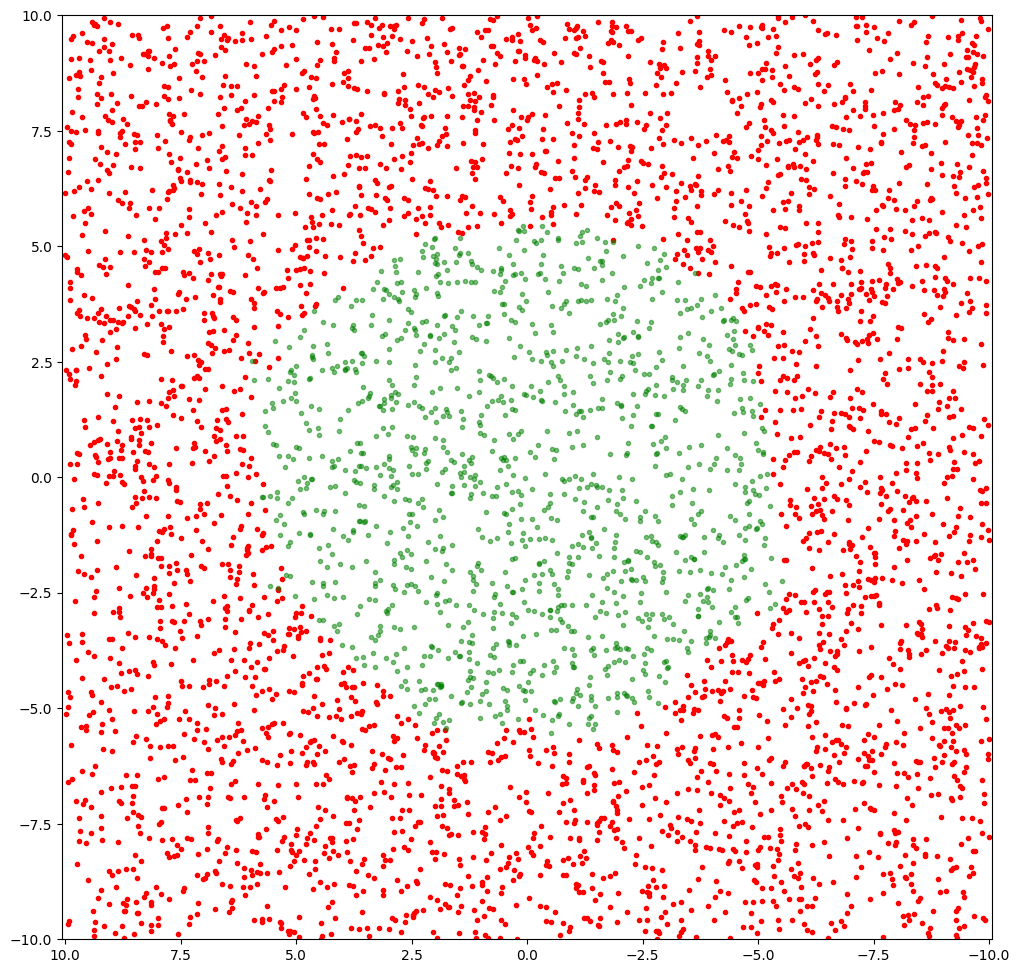

In [ ]:
# hence we need to 'unsort' them using their IDs
import matplotlib.pyplot as plt
surv = part.state.copy()
surv[part.particle_id] = part.state

# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red')
plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green',alpha=0.5)
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
# plt.axis([2.5, -2.5, -2.5, 2.5])
plt.show()

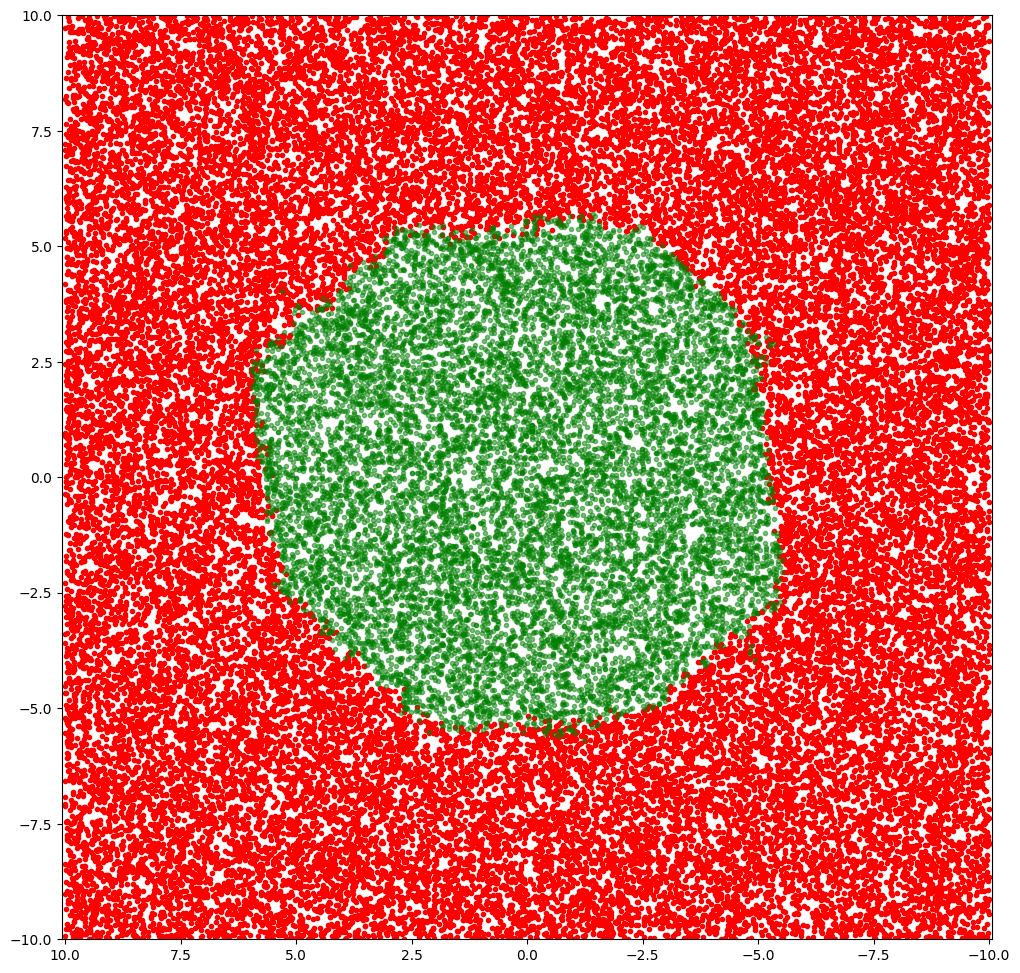

In [ ]:
# hence we need to 'unsort' them using their IDs
surv = part.state.copy()
surv[part.particle_id] = part.state

# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red')
plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green',alpha=0.5)
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
# plt.axis([2.5, -2.5, -2.5, 2.5])
plt.show()

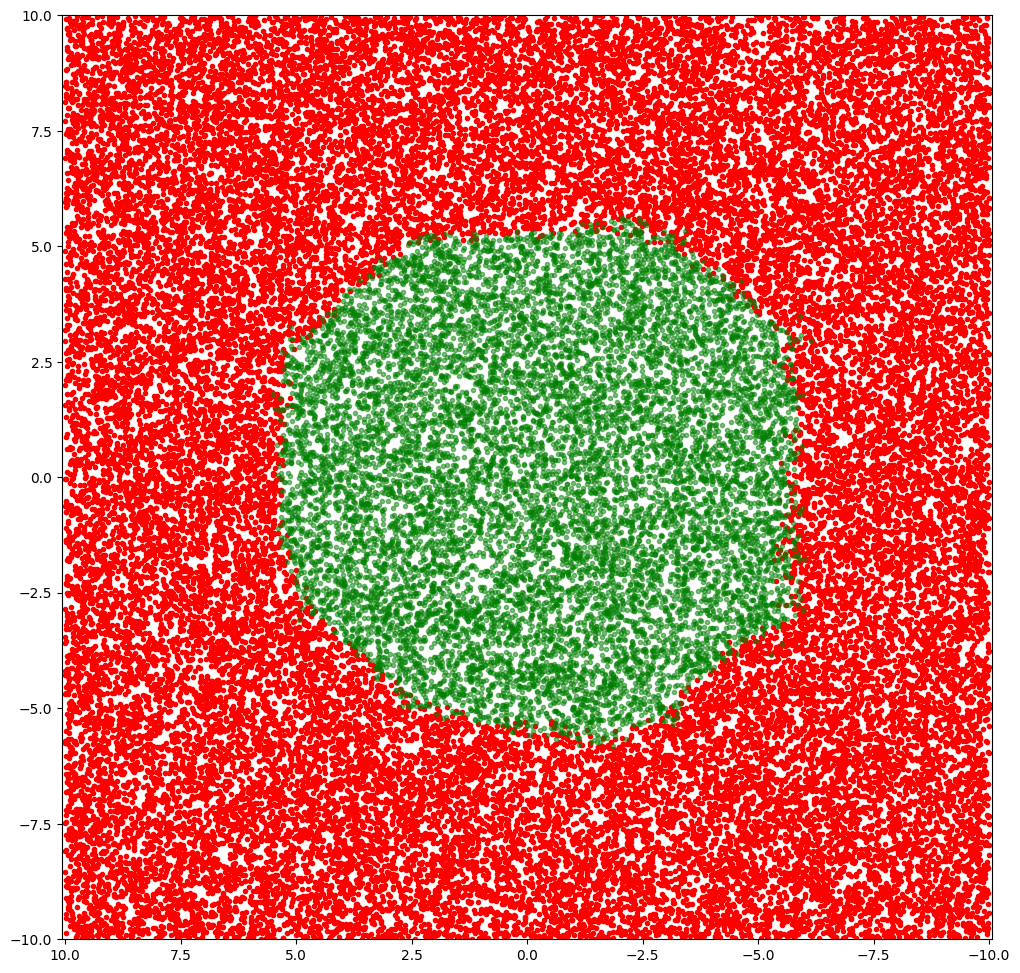

In [ ]:
# hence we need to 'unsort' them using their IDs
surv = part.state.copy()
surv[part.particle_id] = part.state

# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red')
plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green',alpha=0.5)
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
# plt.axis([2.5, -2.5, -2.5, 2.5])
plt.show()

In [ ]:
df2 = tracked.df.copy()
df2 = df2[df2['gamma0'] > 0].reset_index(drop=True)
df2 = df2[df2['at_element'] != 0].reset_index(drop=True)
intensity2 = tracked.df.groupby('at_turn').count().state

In [ ]:
intensity = tracked.df.groupby('at_turn').count().state

In [ ]:
df2.groupby('at_element').count()

start_tracking_at_element     q0  mass0      s   zeta    chi  \
at_element                                                                 
52215                           15325  15325  15325  15325  15325  15325   

            charge_ratio  weight  particle_id  at_turn  ...      y     px  \
at_element                                              ...                 
52215              15325   15325        15325    15325  ...  15325  15325   

               py  delta   ptau    rvv    rpp    p0c  beta0  gamma0  
at_element                                                           
52215       15325  15325  15325  15325  15325  15325  15325   15325  

[1 rows x 27 columns]

(120.0, 150.0)

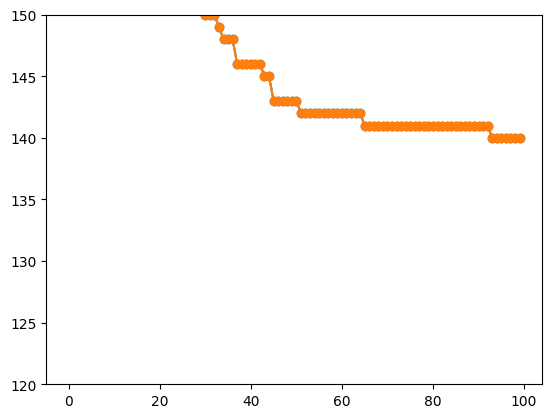

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(intensity,'-o')
plt.plot(intensity2,'-o')
plt.ylim([120,150])

(-10.0, 200.0)

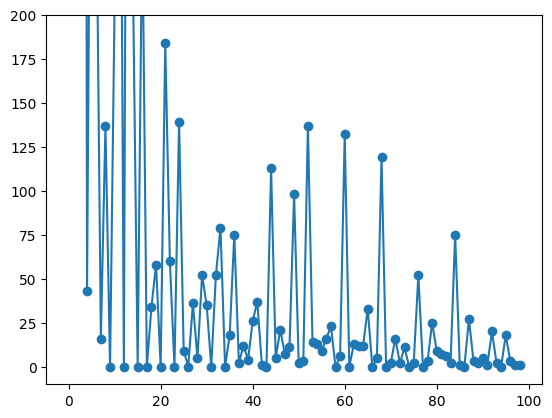

In [ ]:
plt.figure()
plt.plot(-np.diff(intensity),'-o')
plt.ylim([-10,200])




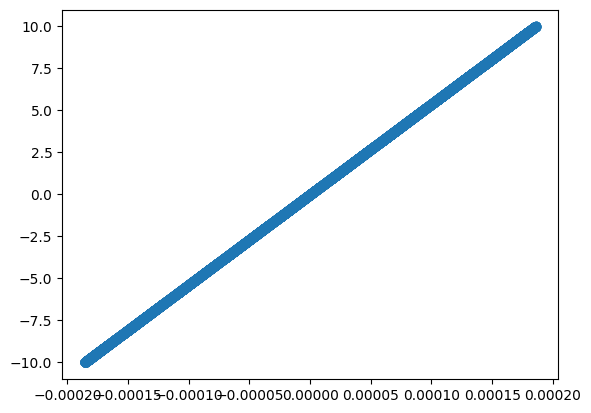

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(tracked.df.groupby('turn').get_group(0).x_n,x_norm,'o')

In [ ]:
tracked.df.groupby('turn').get_group(99).x

100    -0.000568
200    -0.000287
301     0.000546
401    -0.000241
503    -0.000273
639    -0.000433
740    -0.000571
840    -0.000032
940     0.000509
1040    0.000217
1140   -0.000033
1240    0.000041
1340    0.000241
1441   -0.000111
1541   -0.000297
1641    0.000651
1748    0.000009
1850    0.000826
1955    0.000005
2057    0.000290
2157   -0.000610
2259    0.000276
2359   -0.000484
2460    0.000227
2562   -0.000402
Name: x, dtype: float64

In [ ]:
import json

import xtrack as xt
import xpart as xp
import xobjects as xo

context = xo.ContextCpu()

# line_path = '/Users/pbelanger/ABPLocal/BBStudies/Executables/py-BB/xtrack/test_data/hllhc15_noerrors_nobb/line_and_particle.json'
line_path = '/Users/pbelanger/ABPLocal/BBStudies/Executables/py-BB/xtrack/test_data/lhc_with_bb/line_and_particle.json'
# line_path = '../../test_data/hllhc15_noerrors_nobb/line_and_particle.json'
with open(line_path) as f:
    dct = json.load(f)
line = xt.Line.from_dict(dct['line'])
line.particle_ref = xp.Particles.from_dict(dct['particle'])





num_particles = 5000
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=100,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=5, stop_at_turn=15,
                                    num_particles=num_particles)
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')

#============================================================
# - ADDING APERTURE
#============================================================

aper_noproblem = xt.LimitRect(  min_x=-5e-2, max_x=5e-2,  
                                min_y=-5e-2, max_y=5e-2)

aper_problem  =  xt.LimitRect(  min_x=-5e-4, max_x=5e-4,  
                                min_y=-5e-4, max_y=5e-4)
line.insert_element(element=aper_problem, name='aperture', index='mymon5')
#============================================================


line.build_tracker()

# particles = xp.generate_matched_gaussian_bunch(line=line,
#                                                num_particles=num_particles,
#                                                nemitt_x=2.5e-6,
#                                                nemitt_y=2.5e-6,
#                                                sigma_z=9e-2,at_element='tcp.d6l7.b1')


import numpy as np
n_sigmas = 100
n_part   = num_particles
x_norm  = np.random.uniform(-n_sigmas, n_sigmas, n_part) 
px_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
y_norm  = np.random.uniform(-n_sigmas, n_sigmas, n_part) 
py_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
particles = xp.build_particles( line =line,
                            x_norm=x_norm,
                            px_norm=px_norm,
                            y_norm=y_norm,
                            py_norm=py_norm,
                            nemitt_x=2.5e-6, nemitt_y=2.5e-6,
                            _context=context,
                            at_element='mymon5')

num_turns = 100
monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=0, stop_at_turn=15,
                              num_particles=num_particles)
line.track(particles, num_turns=num_turns,turn_by_turn_monitor=monitor_ip5)

Done loading line from dict.           
Compiling ContextCpu kernels...


75790c59adda4629a7a82813e61ee86c.c:5035:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniforge3/envs/py-BB/include/python3.11/pyconfig.h:1690:10: note: previous definition is here
# define _GNU_SOURCE 1
         ^
75790c59adda4629a7a82813e61ee86c.c:16660:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma          = energy / m0;     // [1]
           ^
75790c59adda4629a7a82813e61ee86c.c:16926:9: warning: variable 'i' set but not used [-Wunused-but-set-variable]
    int i=0;
        ^
75790c59adda4629a7a82813e61ee86c.c:17017:12: warning: unused variable 'e_loss_primary_tot' [-Wunused-variable]
    double e_loss_primary_tot = 0.0;  // [GeV] total energy lost by the macroparticle
           ^
75790c59adda4629a7a82813e61ee86c.c:17014:62: warning: variable 'ps_e_prime' set but not used [-Wunused-but-set-varia

Done compiling ContextCpu kernels.


In [ ]:
import pandas as pd
df = pd.DataFrame(monitor_ip5.to_dict()['data'])
# df.groupby('state').get_group(1).groupby('at_element').count()


# pd.DataFrame(monitor_ip5.to_dict()['data']).groupby('at_element').count()

In [ ]:
df = pd.DataFrame(monitor_ip5.to_dict()['data'])

In [ ]:
df[df['state']!=0].groupby('at_turn').count()

start_tracking_at_element    q0  mass0     s  zeta   chi  \
at_turn                                                             
0                             5000  5000   5000  5000  5000  5000   
1                             5000  5000   5000  5000  5000  5000   
2                             4459  4459   4459  4459  4459  4459   
3                             3620  3620   3620  3620  3620  3620   
4                             2734  2734   2734  2734  2734  2734   
...                            ...   ...    ...   ...   ...   ...   
95                            1509  1509   1509  1509  1509  1509   
96                            1502  1502   1502  1502  1502  1502   
97                            1501  1501   1501  1501  1501  1501   
98                            1499  1499   1499  1499  1499  1499   
99                            1496  1496   1496  1496  1496  1496   

         charge_ratio  weight  particle_id  at_element  ...     y    px    py  \
at_turn                                                 ...                     
0                5000    5000         5000        5000  ...  5000  5000  5000   
1                5000    5000         5000        5000  ...  5000  5000  5000   
2                4459    4459         4459        4459  ...  4459  4459  4459   
3                3620    3620         3620        3620  ...  3620  3620  3620   
4                2734    2734         2734        2734  ...  2734  2734  2734   
...               ...     ...          ...         ...  ...   ...   ...   ...   
95               1509    1509         1509        1509  ...  1509  1509  1509   
96               1502    1502         1502        1502  ...  1502  1502  1502   
97               1501    1501         1501        1501  ...  1501  1501  1501   
98               1499    1499         1499        1499  ...  1499  1499  1499   
99               1496    1496         1496        1496  ...  1496  1496  1496   

         delta  ptau   rvv   rpp   p0c  beta0  gamma0  
at_turn                                                
0         5000  5000  5000  5000  5000   5000    5000  
1         5000  5000  5000  5000  5000   5000    5000  
2         4459  4459  4459  4459  4459   4459    4459  
3         3620  3620  3620  3620  3620   3620    3620  
4         2734  2734  2734  2734  2734   2734    2734  
...        ...   ...   ...   ...   ...    ...     ...  
95        1509  1509  1509  1509  1509   1509    1509  
96        1502  1502  1502  1502  1502   1502    1502  
97        1501  1501  1501  1501  1501   1501    1501  
98        1499  1499  1499  1499  1499   1499    1499  
99        1496  1496  1496  1496  1496   1496    1496  

[100 rows x 27 columns]

In [ ]:
df.groupby('state').get_group(0).mean()

start_tracking_at_element    0.0
q0                           0.0
mass0                        0.0
s                            0.0
zeta                         0.0
chi                          0.0
charge_ratio                 0.0
weight                       0.0
particle_id                  0.0
at_element                   0.0
at_turn                      0.0
state                        0.0
parent_particle_id           0.0
_rng_s1                      0.0
_rng_s2                      0.0
_rng_s3                      0.0
_rng_s4                      0.0
x                            0.0
y                            0.0
px                           0.0
py                           0.0
delta                        0.0
ptau                         0.0
rvv                          0.0
rpp                          0.0
p0c                          0.0
beta0                        0.0
gamma0                       0.0
dtype: float64

In [ ]:
df.groupby('at_element').get_group(0).mean()

start_tracking_at_element    0.0
q0                           0.0
mass0                        0.0
s                            0.0
zeta                         0.0
chi                          0.0
charge_ratio                 0.0
weight                       0.0
particle_id                  0.0
at_element                   0.0
at_turn                      0.0
state                        0.0
parent_particle_id           0.0
_rng_s1                      0.0
_rng_s2                      0.0
_rng_s3                      0.0
_rng_s4                      0.0
x                            0.0
y                            0.0
px                           0.0
py                           0.0
delta                        0.0
ptau                         0.0
rvv                          0.0
rpp                          0.0
p0c                          0.0
beta0                        0.0
gamma0                       0.0
dtype: float64

In [ ]:
df.groupby('at_turn').count()

start_tracking_at_element      q0   mass0       s    zeta     chi  \
at_turn                                                                      
0                           329119  329119  329119  329119  329119  329119   
1                             2541    2541    2541    2541    2541    2541   
2                             2541    2541    2541    2541    2541    2541   
3                             2441    2441    2441    2441    2441    2441   
4                             2354    2354    2354    2354    2354    2354   
...                            ...     ...     ...     ...     ...     ...   
95                            1465    1465    1465    1465    1465    1465   
96                            1463    1463    1463    1463    1463    1463   
97                            1461    1461    1461    1461    1461    1461   
98                            1456    1456    1456    1456    1456    1456   
99                            1455    1455    1455    1455    1455    1455   

         charge_ratio  weight  particle_id  at_element  ...       y      px  \
at_turn                                                 ...                   
0              329119  329119       329119      329119  ...  329119  329119   
1                2541    2541         2541        2541  ...    2541    2541   
2                2541    2541         2541        2541  ...    2541    2541   
3                2441    2441         2441        2441  ...    2441    2441   
4                2354    2354         2354        2354  ...    2354    2354   
...               ...     ...          ...         ...  ...     ...     ...   
95               1465    1465         1465        1465  ...    1465    1465   
96               1463    1463         1463        1463  ...    1463    1463   
97               1461    1461         1461        1461  ...    1461    1461   
98               1456    1456         1456        1456  ...    1456    1456   
99               1455    1455         1455        1455  ...    1455    1455   

             py   delta    ptau     rvv     rpp     p0c   beta0  gamma0  
at_turn                                                                  
0        329119  329119  329119  329119  329119  329119  329119  329119  
1          2541    2541    2541    2541    2541    2541    2541    2541  
2          2541    2541    2541    2541    2541    2541    2541    2541  
3          2441    2441    2441    2441    2441    2441    2441    2441  
4          2354    2354    2354    2354    2354    2354    2354    2354  
...         ...     ...     ...     ...     ...     ...     ...     ...  
95         1465    1465    1465    1465    1465    1465    1465    1465  
96         1463    1463    1463    1463    1463    1463    1463    1463  
97         1461    1461    1461    1461    1461    1461    1461    1461  
98         1456    1456    1456    1456    1456    1456    1456    1456  
99         1455    1455    1455    1455    1455    1455    1455    1455  

[100 rows x 27 columns]

In [ ]:
pd.DataFrame(monitor_ip8.to_dict()['data']).groupby('at_turn').count()

start_tracking_at_element  q0  mass0   s  zeta  chi  charge_ratio  \
at_turn                                                                      
0                               61  61     61  61    61   61            61   
5                               46  46     46  46    46   46            46   
6                               46  46     46  46    46   46            46   
7                               45  45     45  45    45   45            45   
8                               45  45     45  45    45   45            45   
9                               43  43     43  43    43   43            43   
10                              43  43     43  43    43   43            43   
11                              43  43     43  43    43   43            43   
12                              43  43     43  43    43   43            43   
13                              43  43     43  43    43   43            43   
14                              42  42     42  42    42   42            42   

         weight  particle_id  at_element  ...   y  px  py  delta  ptau  rvv  \
at_turn                                   ...                                 
0            61           61          61  ...  61  61  61     61    61   61   
5            46           46          46  ...  46  46  46     46    46   46   
6            46           46          46  ...  46  46  46     46    46   46   
7            45           45          45  ...  45  45  45     45    45   45   
8            45           45          45  ...  45  45  45     45    45   45   
9            43           43          43  ...  43  43  43     43    43   43   
10           43           43          43  ...  43  43  43     43    43   43   
11           43           43          43  ...  43  43  43     43    43   43   
12           43           43          43  ...  43  43  43     43    43   43   
13           43           43          43  ...  43  43  43     43    43   43   
14           42           42          42  ...  42  42  42     42    42   42   

         rpp  p0c  beta0  gamma0  
at_turn                           
0         61   61     61      61  
5         46   46     46      46  
6         46   46     46      46  
7         45   45     45      45  
8         45   45     45      45  
9         43   43     43      43  
10        43   43     43      43  
11        43   43     43      43  
12        43   43     43      43  
13        43   43     43      43  
14        42   42     42      42  

[11 rows x 27 columns]

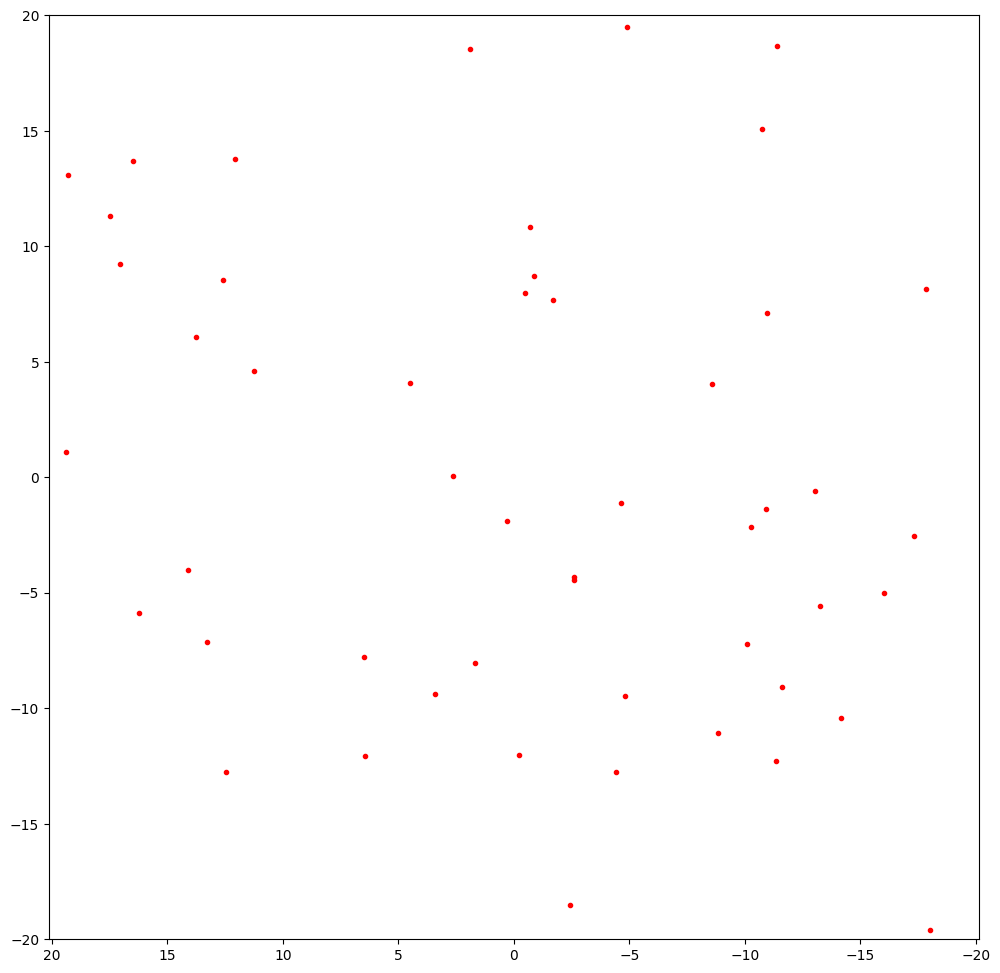

In [ ]:
# hence we need to 'unsort' them using their IDs
import matplotlib.pyplot as plt
surv = particles.state.copy()
surv[particles.particle_id] = particles.state

# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red')
plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green',alpha=0.5)
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
# plt.axis([2.5, -2.5, -2.5, 2.5])
plt.show()

In [ ]:
tracked.df.groupby('turn').get_group(99).particle

199      1
299      2
499      4
599      5
899      8
1499    14
1699    16
1799    17
1899    18
1999    19
2099    20
2199    21
2299    22
2499    24
2599    25
2699    26
3099    30
3399    33
3699    36
3999    39
4099    40
4399    43
4499    44
4699    46
4999    49
Name: particle, dtype: int64

In [ ]:
import numpy as np

import xobjects as xo
import xtrack as xt
import xpart as xp
import pandas as pd

## Generate a simple line
line = xt.Line(
    elements=[xt.Drift(length=2.),
              xt.Multipole(knl=[0, 1.], ksl=[0,0]),
              xt.Drift(length=1.),
              xt.Multipole(knl=[0, -1.], ksl=[0,0])],
    element_names=['drift_0', 'quad_0', 'drift_1', 'quad_1'])

## Attach a reference particle to the line (optional)
## (defines the reference mass, charge and energy)
line.particle_ref = xp.Particles(p0c=6500e9, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)





#============================================================
# - ADDING APERTURE
#============================================================

aper_1 = xt.LimitRect(  min_x=-1e-3, max_x=1e-3,  
                        min_y=-2e-3, max_y=2e-3)
line.insert_element(element=aper_1, name='aperture', index='drift_1')
#============================================================


## Choose a context
context = xo.ContextCpu()         # For CPU
# context = xo.ContextCupy()      # For CUDA GPUs
# context = xo.ContextPyopencl()  # For OpenCL GPUs

## Transfer lattice on context and compile tracking code
line.build_tracker(_context=context)

## Build particle object on context
n_part = 200
particles = xp.Particles(p0c=6500e9, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=np.random.uniform(-1e-3, 1e-3, n_part),
                        px=np.random.uniform(-1e-5, 1e-5, n_part),
                        y=np.random.uniform(-2e-3, 2e-3, n_part),
                        py=np.random.uniform(-3e-5, 3e-5, n_part),
                        zeta=np.random.uniform(-1e-2, 1e-2, n_part),
                        delta=np.random.uniform(-1e-4, 1e-4, n_part),
                        _context=context)

## Track (saving turn-by-turn data)
n_turns = 100
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True)




## Turn-by-turn data is available at:
# line.record_last_track.x
# line.record_last_track.px

# One can see that there are thousands of particles with at_turn=0
print(np.bincount(line.record_last_track.to_dict()['data']['at_turn']))

# Or via dataframe:
df = pd.DataFrame(line.record_last_track.to_dict()['data'])
print(df.groupby('at_turn').count())



Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
[10201   195    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98    98    98    98    98    98    98    98    98
    98    98    98    98]
         start_tracking_at_element     q0  mass0      s   zeta    chi  \
at_turn                                                                 
0                            10201  10201  10201  10201  10201  10201   
1                              195    195    195    195    195    195   
2                               98     98     98     98     98 

In [ ]:
import pandas as pd
df = pd.DataFrame(line.record_last_track.to_dict()['data'])
df.groupby('at_turn').count()

start_tracking_at_element    q0  mass0     s  zeta   chi  \
at_turn                                                             
0                             9645  9645   9645  9645  9645  9645   
1                              197   197    197   197   197   197   
2                              104   104    104   104   104   104   
3                              104   104    104   104   104   104   
4                              104   104    104   104   104   104   
...                            ...   ...    ...   ...   ...   ...   
95                             103   103    103   103   103   103   
96                             103   103    103   103   103   103   
97                             103   103    103   103   103   103   
98                             103   103    103   103   103   103   
99                             103   103    103   103   103   103   

         charge_ratio  weight  particle_id  at_element  ...     y    px    py  \
at_turn                                                 ...                     
0                9645    9645         9645        9645  ...  9645  9645  9645   
1                 197     197          197         197  ...   197   197   197   
2                 104     104          104         104  ...   104   104   104   
3                 104     104          104         104  ...   104   104   104   
4                 104     104          104         104  ...   104   104   104   
...               ...     ...          ...         ...  ...   ...   ...   ...   
95                103     103          103         103  ...   103   103   103   
96                103     103          103         103  ...   103   103   103   
97                103     103          103         103  ...   103   103   103   
98                103     103          103         103  ...   103   103   103   
99                103     103          103         103  ...   103   103   103   

         delta  ptau   rvv   rpp   p0c  beta0  gamma0  
at_turn                                                
0         9645  9645  9645  9645  9645   9645    9645  
1          197   197   197   197   197    197     197  
2          104   104   104   104   104    104     104  
3          104   104   104   104   104    104     104  
4          104   104   104   104   104    104     104  
...        ...   ...   ...   ...   ...    ...     ...  
95         103   103   103   103   103    103     103  
96         103   103   103   103   103    103     103  
97         103   103   103   103   103    103     103  
98         103   103   103   103   103    103     103  
99         103   103   103   103   103    103     103  

[100 rows x 27 columns]

In [ ]:
np.bincount(line.record_last_track.to_dict()['data']['at_turn'])

array([9645,  197,  104,  104,  104,  104,  104,  104,  104,  104,  104,
        104,  104,  104,  104,  104,  104,  104,  104,  104,  104,  104,
        104,  104,  104,  104,  104,  104,  104,  104,  104,  104,  104,
        104,  104,  104,  104,  104,  104,  104,  104,  104,  104,  104,
        104,  104,  104,  104,  104,  104,  104,  104,  104,  104,  104,
        104,  104,  104,  104,  104,  104,  104,  104,  104,  104,  104,
        103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
        103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
        103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
        103])

In [ ]:
df.groupby('at_turn').count()

start_tracking_at_element   q0  mass0    s  zeta  chi  charge_ratio  \
at_turn                                                                        
0                              200  200    200  200   200  200           200   
1                              200  200    200  200   200  200           200   
2                              200  200    200  200   200  200           200   
3                              200  200    200  200   200  200           200   
4                              200  200    200  200   200  200           200   
...                            ...  ...    ...  ...   ...  ...           ...   
95                             200  200    200  200   200  200           200   
96                             200  200    200  200   200  200           200   
97                             200  200    200  200   200  200           200   
98                             200  200    200  200   200  200           200   
99                             200  200    200  200   200  200           200   

         weight  particle_id  at_element  ...    y   px   py  delta  ptau  \
at_turn                                   ...                               
0           200          200         200  ...  200  200  200    200   200   
1           200          200         200  ...  200  200  200    200   200   
2           200          200         200  ...  200  200  200    200   200   
3           200          200         200  ...  200  200  200    200   200   
4           200          200         200  ...  200  200  200    200   200   
...         ...          ...         ...  ...  ...  ...  ...    ...   ...   
95          200          200         200  ...  200  200  200    200   200   
96          200          200         200  ...  200  200  200    200   200   
97          200          200         200  ...  200  200  200    200   200   
98          200          200         200  ...  200  200  200    200   200   
99          200          200         200  ...  200  200  200    200   200   

         rvv  rpp  p0c  beta0  gamma0  
at_turn                                
0        200  200  200    200     200  
1        200  200  200    200     200  
2        200  200  200    200     200  
3        200  200  200    200     200  
4        200  200  200    200     200  
...      ...  ...  ...    ...     ...  
95       200  200  200    200     200  
96       200  200  200    200     200  
97       200  200  200    200     200  
98       200  200  200    200     200  
99       200  200  200    200     200  

[100 rows x 27 columns]

In [ ]:
import numpy as np

import xobjects as xo
import xtrack as xt
import xpart as xp
import pandas as pd

## Generate a simple line
line = xt.Line(
    elements=[xt.Drift(length=2.),
              xt.Multipole(knl=[0, 1.], ksl=[0,0]),
              xt.Drift(length=1.),
              xt.Multipole(knl=[0, -1.], ksl=[0,0])],
    element_names=['drift_0', 'quad_0', 'drift_1', 'quad_1'])

## Attach a reference particle to the line (optional)
## (defines the reference mass, charge and energy)
line.particle_ref = xp.Particles(p0c=6500e9, #eV
                                 q0=1, mass0=xp.PROTON_MASS_EV)





#============================================================
# - ADDING APERTURE
#============================================================

aper_1 = xt.LimitRect(  min_x=-1e-3, max_x=1e-3,  
                        min_y=-2e-3, max_y=2e-3)
line.insert_element(element=aper_1, name='aperture', index='drift_1')
#============================================================


## Choose a context
context = xo.ContextCpu()         # For CPU
# context = xo.ContextCupy()      # For CUDA GPUs
# context = xo.ContextPyopencl()  # For OpenCL GPUs

## Transfer lattice on context and compile tracking code
line.build_tracker(_context=context)

## Build particle object on context
n_part = 200
particles = xp.Particles(p0c=6500e9, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=np.random.uniform(-1e-3, 1e-3, n_part),
                        px=np.random.uniform(-1e-5, 1e-5, n_part),
                        y=np.random.uniform(-2e-3, 2e-3, n_part),
                        py=np.random.uniform(-3e-5, 3e-5, n_part),
                        zeta=np.random.uniform(-1e-2, 1e-2, n_part),
                        delta=np.random.uniform(-1e-4, 1e-4, n_part),
                        _context=context)

## Track (saving turn-by-turn data)
n_turns = 100
line.track(particles, num_turns=n_turns,
              turn_by_turn_monitor=True)




## Turn-by-turn data is available at:
# line.record_last_track.x
# line.record_last_track.px

# One can see that there are thousands of particles with at_turn=0
print(np.bincount(line.record_last_track.to_dict()['data']['at_turn']))

# Or via dataframe:
df = pd.DataFrame(line.record_last_track.to_dict()['data'])
print(df.groupby('at_turn').count())



Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
[10687   199    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93    93    93    93    93    93    93    93    93
    93    93    93    93]
         start_tracking_at_element     q0  mass0      s   zeta    chi  \
at_turn                                                                 
0                            10687  10687  10687  10687  10687  10687   
1                              199    199    199    199    199    199   
2                               93     93     93     93     93 

In [ ]:
df[df.state != 0].gamma0.mean()

6927.628083302592

In [ ]:
rich.inspect(collider['lhcb1'].element_dict['tcp.c6l7.b1_aper'])

╭───────────────────────────── <class 'xtrack.beam_elements.apertures.LimitPolygon'> ─────────────────────────────╮
│ Beam element modeling a polygonal aperture limit.                                                               │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ LimitPolygon(x_vertices=[ 0.001301  0.001301 -0.001301 -0.001301], y_vertices=[-1.  1.  1. -1.],            │ │
│ │ x_normal=[-1. -0.  1. -0.], y_normal=[ 0. -1.  0.  1.], resc_fac=1.0)                                       │ │
│ ╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                                 │
│                  allow_backtrack = False                                                                        │
│                             area = 0.005204                                                                     │
│               behaves_like_drift = False                                                                        │
│                         centroid = (0.0, 0.0)                                                                   │
│                          context = <xobjects.context_cpu.ContextCpu object at 0x12ed69ad0>                      │
│                    extra_sources = NameError('`extra_sources` has been removed. Use `_extra_c_sources`          │
│                                    instead.')                                                                   │
│                    has_backtrack = True                                                                         │
│                     iscollective = None                                                                         │
│                          isthick = False                                                                        │
│                         resc_fac = 1.0                                                                          │
│ skip_in_loss_location_refinement = False                                                                        │
│                         x_closed = array([ 0.001301,  0.001301, -0.001301, -0.001301,  0.001301])               │
│                         x_normal = array([-1., -0.,  1., -0.])                                                  │
│                       x_vertices = array([ 0.001301,  0.001301, -0.001301, -0.001301])                          │
│                         XoStruct = NameError('`XoStruct` has been removed. Use `_XoStruct` instead.')           │
│                         y_closed = array([-1.,  1.,  1., -1., -1.])                                             │
│                         y_normal = array([ 0., -1.,  0.,  1.])                                                  │
│                       y_vertices = array([-1.,  1.,  1., -1.])                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
part.to_pandas()['state']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
40    0
41    0
42    0
43    0
44    0
45    0
46    0
47    0
48    0
49    0
Name: state, dtype: int64

In [ ]:
df.groupby('at_element').count()

start_tracking_at_element    q0  mass0     s  zeta   chi  \
at_element                                                             
0                                5000  5000   5000  5000  5000  5000   

            charge_ratio  weight  particle_id  at_turn  ...     y    px    py  \
at_element                                              ...                     
0                   5000    5000         5000     5000  ...  5000  5000  5000   

            delta  ptau   rvv   rpp   p0c  beta0  gamma0  
at_element                                                
0            5000  5000  5000  5000  5000   5000    5000  

[1 rows x 27 columns]

In [ ]:
df.groupby('particle_id').get_group(2)

start_tracking_at_element   q0  mass0           s          zeta  chi  \
200                          0  0.0    0.0  13124.4636  5.518675e-06  1.0   
201                          0  0.0    0.0      0.0000  9.134051e-07  1.0   
202                          0  0.0    0.0      0.0000  1.275112e-06  1.0   
203                          0  0.0    0.0      0.0000  1.472732e-06  1.0   
204                          0  0.0    0.0      0.0000  9.882980e-07  1.0   
..                         ...  ...    ...         ...           ...  ...   
295                          0  0.0    0.0      0.0000  1.182552e-06  1.0   
296                          0  0.0    0.0      0.0000  1.516424e-06  1.0   
297                          0  0.0    0.0      0.0000  1.075845e-06  1.0   
298                          0  0.0    0.0      0.0000  1.016712e-06  1.0   
299                          0  0.0    0.0      0.0000  1.494418e-06  1.0   

     charge_ratio  weight  particle_id  at_element  ...             y  \
200           1.0     0.0            2       52214  ... -1.020743e-06   
201           1.0     0.0            2           0  ...  1.662147e-06   
202           1.0     0.0            2           0  ...  3.526541e-07   
203           1.0     0.0            2           0  ... -2.000979e-06   
204           1.0     0.0            2           0  ...  7.810839e-07   
..            ...     ...          ...         ...  ...           ...   
295           1.0     0.0            2           0  ...  9.695222e-07   
296           1.0     0.0            2           0  ... -1.967585e-06   
297           1.0     0.0            2           0  ...  1.437838e-07   
298           1.0     0.0            2           0  ...  1.758351e-06   
299           1.0     0.0            2           0  ... -1.356362e-06   

               px            py     delta      ptau  rvv       rpp  \
200 -4.304469e-08 -2.085819e-08  0.000001  0.000001  1.0  0.999999   
201  3.365781e-07  2.428107e-08  0.000001  0.000001  1.0  0.999999   
202 -2.828636e-08 -4.835728e-09  0.000001  0.000001  1.0  0.999999   
203 -3.385974e-07 -2.321418e-08  0.000001  0.000001  1.0  0.999999   
204  2.196326e-07  1.738860e-08  0.000001  0.000001  1.0  0.999999   
..            ...           ...       ...       ...  ...       ...   
295  9.063738e-08  3.691315e-09  0.000001  0.000001  1.0  0.999999   
296 -3.629710e-07 -2.586038e-08  0.000001  0.000001  1.0  0.999999   
297  1.158035e-07  1.052539e-08  0.000001  0.000001  1.0  0.999999   
298  2.709427e-07  1.734104e-08  0.000001  0.000001  1.0  0.999999   
299 -3.046690e-07 -2.328218e-08  0.000001  0.000001  1.0  0.999999   

              p0c  beta0       gamma0  
200  6.800000e+12    1.0  7247.364689  
201  6.800000e+12    1.0  7247.364689  
202  6.800000e+12    1.0  7247.364689  
203  6.800000e+12    1.0  7247.364689  
204  6.800000e+12    1.0  7247.364689  
..            ...    ...          ...  
295  6.800000e+12    1.0  7247.364689  
296  6.800000e+12    1.0  7247.364689  
297  6.800000e+12    1.0  7247.364689  
298  6.800000e+12    1.0  7247.364689  
299  6.800000e+12    1.0  7247.364689  

[100 rows x 28 columns]

In [ ]:
test = collider[seq].record_last_track.to_dict()['data']

In [ ]:
test['at_turn']

array([ 0,  1,  2, ..., 97, 98, 99])

In [ ]:
len(test['at_turn'])

5000

In [ ]:
part.to_pandas()

start_tracking_at_element   q0         mass0           s          zeta  \
0                          -1  1.0  9.382721e+08      0.0000  1.889227e-06   
1                          -1  1.0  9.382721e+08      0.0000  3.371739e-05   
2                          -1  1.0  9.382721e+08      0.0000  3.615798e-05   
3                          -1  1.0  9.382721e+08      0.0000  9.741035e-06   
4                          -1  1.0  9.382721e+08      0.0000  1.295431e-06   
5                          -1  1.0  9.382721e+08      0.0000  1.487920e-06   
6                          -1  1.0  9.382721e+08      0.0000 -2.396610e-07   
7                          -1  1.0  9.382721e+08      0.0000  3.660551e-05   
8                          -1  1.0  9.382721e+08      0.0000  4.024559e-05   
9                          -1  1.0  9.382721e+08      0.0000  1.412040e-06   
10                         -1  1.0  9.382721e+08      0.0000  2.084056e-05   
11                         -1  1.0  9.382721e+08      0.0000  1.206463e-05   
12                         -1  1.0  9.382721e+08      0.0000  1.066678e-05   
13                         -1  1.0  9.382721e+08      0.0000  7.604576e-06   
14                         -1  1.0  9.382721e+08      0.0000  1.727938e-05   
15                         -1  1.0  9.382721e+08      0.0000  1.664586e-05   
16                         -1  1.0  9.382721e+08      0.0000 -7.476202e-07   
17                         -1  1.0  9.382721e+08      0.0000  2.455284e-06   
18                         -1  1.0  9.382721e+08      0.0000  4.075303e-05   
19                         -1  1.0  9.382721e+08      0.0000  2.939944e-05   
20                         -1  1.0  9.382721e+08      0.0000  2.823597e-05   
21                         -1  1.0  9.382721e+08      0.0000  6.868247e-06   
22                         -1  1.0  9.382721e+08      0.0000  4.456180e-05   
23                         -1  1.0  9.382721e+08      0.0000  2.080799e-05   
24                         -1  1.0  9.382721e+08      0.0000  5.032917e-07   
25                         -1  1.0  9.382721e+08  13126.4636  6.412540e-06   
26                         -1  1.0  9.382721e+08  13126.4636  5.498871e-06   
27                         -1  1.0  9.382721e+08  13126.4636  4.677158e-06   
28                         -1  1.0  9.382721e+08  13126.4636  6.331971e-06   
29                         -1  1.0  9.382721e+08  13126.4636  6.174114e-06   
30                         -1  1.0  9.382721e+08  13126.4636  5.423908e-06   
31                         -1  1.0  9.382721e+08  13126.4636  4.757046e-06   
32                         -1  1.0  9.382721e+08  13126.4636  6.520125e-06   
33                         -1  1.0  9.382721e+08  13126.4636  6.247401e-06   
34                         -1  1.0  9.382721e+08  13126.4636  5.066995e-06   
35                         -1  1.0  9.382721e+08  13126.4636  5.497666e-06   
36                         -1  1.0  9.382721e+08  13126.4636  4.761256e-06   
37                         -1  1.0  9.382721e+08  13126.4636  6.028113e-06   
38                         -1  1.0  9.382721e+08  13126.4636  4.953102e-06   
39                         -1  1.0  9.382721e+08  13126.4636  5.421915e-06   
40                         -1  1.0  9.382721e+08  13126.4636  6.070851e-06   
41                         -1  1.0  9.382721e+08  13126.4636  5.187185e-06   
42                         -1  1.0  9.382721e+08  13126.4636  6.125863e-06   
43                         -1  1.0  9.382721e+08  13126.4636  4.983831e-06   
44                         -1  1.0  9.382721e+08  13126.4636  5.531398e-06   
45                         -1  1.0  9.382721e+08  13126.4636  5.617950e-06   
46                         -1  1.0  9.382721e+08  13126.4636  5.874685e-06   
47                         -1  1.0  9.382721e+08  13126.4636  5.841425e-06   
48                         -1  1.0  9.382721e+08  13126.4636  5.618346e-06   
49                         -1  1.0  9.382721e+08  13126.4636  5.247766e-06   

    chi  charge_ratio  we

In [ ]:
2525/25

101.0

In [ ]:
df.groupby('at_turn').count()

start_tracking_at_element    q0  mass0     s  zeta   chi  \
at_turn                                                             
0                             2525  2525   2525  2525  2525  2525   
1                               25    25     25    25    25    25   
2                               25    25     25    25    25    25   
3                               25    25     25    25    25    25   
4                               25    25     25    25    25    25   
...                            ...   ...    ...   ...   ...   ...   
95                              25    25     25    25    25    25   
96                              25    25     25    25    25    25   
97                              25    25     25    25    25    25   
98                              25    25     25    25    25    25   
99                              25    25     25    25    25    25   

         charge_ratio  weight  particle_id  at_element  ...     y    px    py  \
at_turn                                                 ...                     
0                2525    2525         2525        2525  ...  2525  2525  2525   
1                  25      25           25          25  ...    25    25    25   
2                  25      25           25          25  ...    25    25    25   
3                  25      25           25          25  ...    25    25    25   
4                  25      25           25          25  ...    25    25    25   
...               ...     ...          ...         ...  ...   ...   ...   ...   
95                 25      25           25          25  ...    25    25    25   
96                 25      25           25          25  ...    25    25    25   
97                 25      25           25          25  ...    25    25    25   
98                 25      25           25          25  ...    25    25    25   
99                 25      25           25          25  ...    25    25    25   

         delta  ptau   rvv   rpp   p0c  beta0  gamma0  
at_turn                                                
0         2525  2525  2525  2525  2525   2525    2525  
1           25    25    25    25    25     25      25  
2           25    25    25    25    25     25      25  
3           25    25    25    25    25     25      25  
4           25    25    25    25    25     25      25  
...        ...   ...   ...   ...   ...    ...     ...  
95          25    25    25    25    25     25      25  
96          25    25    25    25    25     25      25  
97          25    25    25    25    25     25      25  
98          25    25    25    25    25     25      25  
99          25    25    25    25    25     25      25  

[100 rows x 27 columns]

In [ ]:
part0 = tracked.df.groupby('particle_id').get_group(0)
part1 = tracked.df.groupby('particle_id').get_group(1)

_part0 = _tracked.df.groupby('particle_id').get_group(0)
# _part1 = _tracked.df.groupby('particle_id').get_group(1)

In [ ]:
_tracked.df.groupby('at_turn').count()

start_tracking_at_element    q0  mass0     s  zeta   chi  \
at_turn                                                             
0                             2809  2809   2809  2809  2809  2809   
1                               24    24     24    24    24    24   
2                               24    24     24    24    24    24   
3                               24    24     24    24    24    24   
4                               24    24     24    24    24    24   
...                            ...   ...    ...   ...   ...   ...   
95                              22    22     22    22    22    22   
96                              22    22     22    22    22    22   
97                              22    22     22    22    22    22   
98                              22    22     22    22    22    22   
99                              22    22     22    22    22    22   

         charge_ratio  weight  particle_id  at_element  ...     y    px    py  \
at_turn                                                 ...                     
0                2809    2809         2809        2809  ...  2809  2809  2809   
1                  24      24           24          24  ...    24    24    24   
2                  24      24           24          24  ...    24    24    24   
3                  24      24           24          24  ...    24    24    24   
4                  24      24           24          24  ...    24    24    24   
...               ...     ...          ...         ...  ...   ...   ...   ...   
95                 22      22           22          22  ...    22    22    22   
96                 22      22           22          22  ...    22    22    22   
97                 22      22           22          22  ...    22    22    22   
98                 22      22           22          22  ...    22    22    22   
99                 22      22           22          22  ...    22    22    22   

         delta  ptau   rvv   rpp   p0c  beta0  gamma0  
at_turn                                                
0         2809  2809  2809  2809  2809   2809    2809  
1           24    24    24    24    24     24      24  
2           24    24    24    24    24     24      24  
3           24    24    24    24    24     24      24  
4           24    24    24    24    24     24      24  
...        ...   ...   ...   ...   ...    ...     ...  
95          22    22    22    22    22     22      22  
96          22    22    22    22    22     22      22  
97          22    22    22    22    22     22      22  
98          22    22    22    22    22     22      22  
99          22    22    22    22    22     22      22  

[100 rows x 27 columns]

In [ ]:
part.to_pandas()

start_tracking_at_element   q0         mass0           s      zeta  chi  \
0                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
1                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
2                       52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
3                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
4                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
5                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
6                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
7                       52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
8                       52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
9                       52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
10                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
11                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
12                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
13                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
14                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
15                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
16                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
17                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
18                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
19                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
20                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
21                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
22                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
23                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
24                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
25                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
26                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
27                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
28                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
29                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
30                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
31                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
32                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
33                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
34                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
35                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
36                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
37                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
38                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
39                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
40                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
41                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
42                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
43                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
44                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
45                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
46                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
47                      52215  1.0  9.382721e+08  13124.4636  0.000005  1.0   
48                      52215  1.0  9.382721e+08  13124.4636  0.000006  1.0   
49                      52215  1.0  9.382721e+08  1312

In [ ]:
part0

start_tracking_at_element   q0  mass0           s      zeta  chi  \
0                             0  0.0    0.0  13124.4636  0.000005  1.0   
1                             0  0.0    0.0      0.0000  0.000000  0.0   
2                             0  0.0    0.0      0.0000  0.000000  0.0   
3                             0  0.0    0.0      0.0000  0.000000  0.0   
4                             0  0.0    0.0      0.0000  0.000000  0.0   
...                         ...  ...    ...         ...       ...  ...   
4695                          0  0.0    0.0      0.0000  0.000000  0.0   
4696                          0  0.0    0.0      0.0000  0.000000  0.0   
4697                          0  0.0    0.0      0.0000  0.000000  0.0   
4698                          0  0.0    0.0      0.0000  0.000000  0.0   
4699                          0  0.0    0.0      0.0000  0.000000  0.0   

      charge_ratio  weight  particle_id  at_element  ...         y        px  \
0              1.0     0.0            0       52215  ... -0.000077  0.000022   
1              0.0     0.0            0           0  ...  0.000000  0.000000   
2              0.0     0.0            0           0  ...  0.000000  0.000000   
3              0.0     0.0            0           0  ...  0.000000  0.000000   
4              0.0     0.0            0           0  ...  0.000000  0.000000   
...            ...     ...          ...         ...  ...       ...       ...   
4695           0.0     0.0            0           0  ...  0.000000  0.000000   
4696           0.0     0.0            0           0  ...  0.000000  0.000000   
4697           0.0     0.0            0           0  ...  0.000000  0.000000   
4698           0.0     0.0            0           0  ...  0.000000  0.000000   
4699           0.0     0.0            0           0  ...  0.000000  0.000000   

                py     delta      ptau  rvv       rpp           p0c  beta0  \
0    -2.048931e-08  0.000001  0.000001  1.0  0.999999  6.800000e+12    1.0   
1     0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
2     0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
3     0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
4     0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
...            ...       ...       ...  ...       ...           ...    ...   
4695  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
4696  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
4697  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
4698  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   
4699  0.000000e+00  0.000000  0.000000  0.0  0.000000  0.000000e+00    0.0   

           gamma0  
0     7247.364689  
1        0.000000  
2        0.000000  
3        0.000000  
4        0.000000  
...           ...  
4695     0.000000  
4696     0.000000  
4697     0.000000  
4698     0.000000  
4699     0.000000  

[2361 rows x 28 columns]

In [ ]:
line.record_last_track.to_dict()['data']

{'start_tracking_at_element': 0,
 'q0': 0.0,
 'mass0': 0.0,
 's': array([0., 0., 0., ..., 0., 0., 0.]),
 'zeta': array([0., 0., 0., ..., 0., 0., 0.]),
 'chi': array([0., 0., 0., ..., 0., 0., 0.]),
 'charge_ratio': array([0., 0., 0., ..., 0., 0., 0.]),
 'weight': array([0., 0., 0., ..., 0., 0., 0.]),
 'particle_id': array([0, 0, 0, ..., 0, 0, 0]),
 'at_element': array([0, 0, 0, ..., 0, 0, 0]),
 'at_turn': array([0, 0, 0, ..., 0, 0, 0]),
 'state': array([0, 0, 0, ..., 0, 0, 0]),
 'parent_particle_id': array([0, 0, 0, ..., 0, 0, 0]),
 '_rng_s1': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 '_rng_s2': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 '_rng_s3': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 '_rng_s4': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'x': array([0., 0., 0., ..., 0., 0., 0.]),
 'y': array([0., 0., 0., ..., 0., 0., 0.]),
 'px': array([0., 0., 0., ..., 0., 0., 0.]),
 'py': array([0., 0., 0., ..., 0., 0., 0.]),
 'delta': LinkedArrayCpu([0., 0., 0., ..., 0., 0., 0.

In [ ]:
part.to_dict()['at_element']

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0, 52231,
       52231, 52231, 52231, 52231, 52231, 52231, 52231, 52231, 52231,
       52231, 52231, 52231, 52231, 52231, 52231, 52231, 52231, 52231,
       52231, 52231, 52231, 52231, 52231])

In [ ]:
part.to_pandas().groupby('start_tracking_at_element').count()

q0  mass0   s  zeta  chi  charge_ratio  weight  \
start_tracking_at_element                                                   
-1                         50     50  50    50   50            50      50   

                           particle_id  at_element  at_turn  ...   y  px  py  \
start_tracking_at_element                                    ...               
-1                                  50          50       50  ...  50  50  50   

                           delta  ptau  rvv  rpp  p0c  beta0  gamma0  
start_tracking_at_element                                             
-1                            50    50   50   50   50     50      50  

[1 rows x 27 columns]

In [ ]:
df

start_tracking_at_element   q0  mass0    s  zeta  chi  charge_ratio  \
0                             0  0.0    0.0  0.0   0.0  0.0           0.0   
1                             0  0.0    0.0  0.0   0.0  0.0           0.0   
2                             0  0.0    0.0  0.0   0.0  0.0           0.0   
3                             0  0.0    0.0  0.0   0.0  0.0           0.0   
4                             0  0.0    0.0  0.0   0.0  0.0           0.0   
...                         ...  ...    ...  ...   ...  ...           ...   
4895                          0  0.0    0.0  0.0   0.0  0.0           0.0   
4896                          0  0.0    0.0  0.0   0.0  0.0           0.0   
4897                          0  0.0    0.0  0.0   0.0  0.0           0.0   
4898                          0  0.0    0.0  0.0   0.0  0.0           0.0   
4899                          0  0.0    0.0  0.0   0.0  0.0           0.0   

      weight  particle_id  at_element  ...    y   px   py  delta  ptau  rvv  \
0        0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
1        0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
2        0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
3        0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
4        0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
...      ...          ...         ...  ...  ...  ...  ...    ...   ...  ...   
4895     0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
4896     0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
4897     0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
4898     0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   
4899     0.0            0           0  ...  0.0  0.0  0.0    0.0   0.0  0.0   

      rpp  p0c  beta0  gamma0  
0     0.0  0.0    0.0     0.0  
1     0.0  0.0    0.0     0.0  
2     0.0  0.0    0.0     0.0  
3     0.0  0.0    0.0     0.0  
4     0.0  0.0    0.0     0.0  
...   ...  ...    ...     ...  
4895  0.0  0.0    0.0     0.0  
4896  0.0  0.0    0.0     0.0  
4897  0.0  0.0    0.0     0.0  
4898  0.0  0.0    0.0     0.0  
4899  0.0  0.0    0.0     0.0  

[4900 rows x 28 columns]

In [ ]:
line.vars['on_x1']._

Warning! The argument tracker is deprecated. Please use line instead.
Warning! scale_with_transverse_norm_emitt is deprecated. Use nemitt_x and nemitt_y instead.
Tracking first test.. 


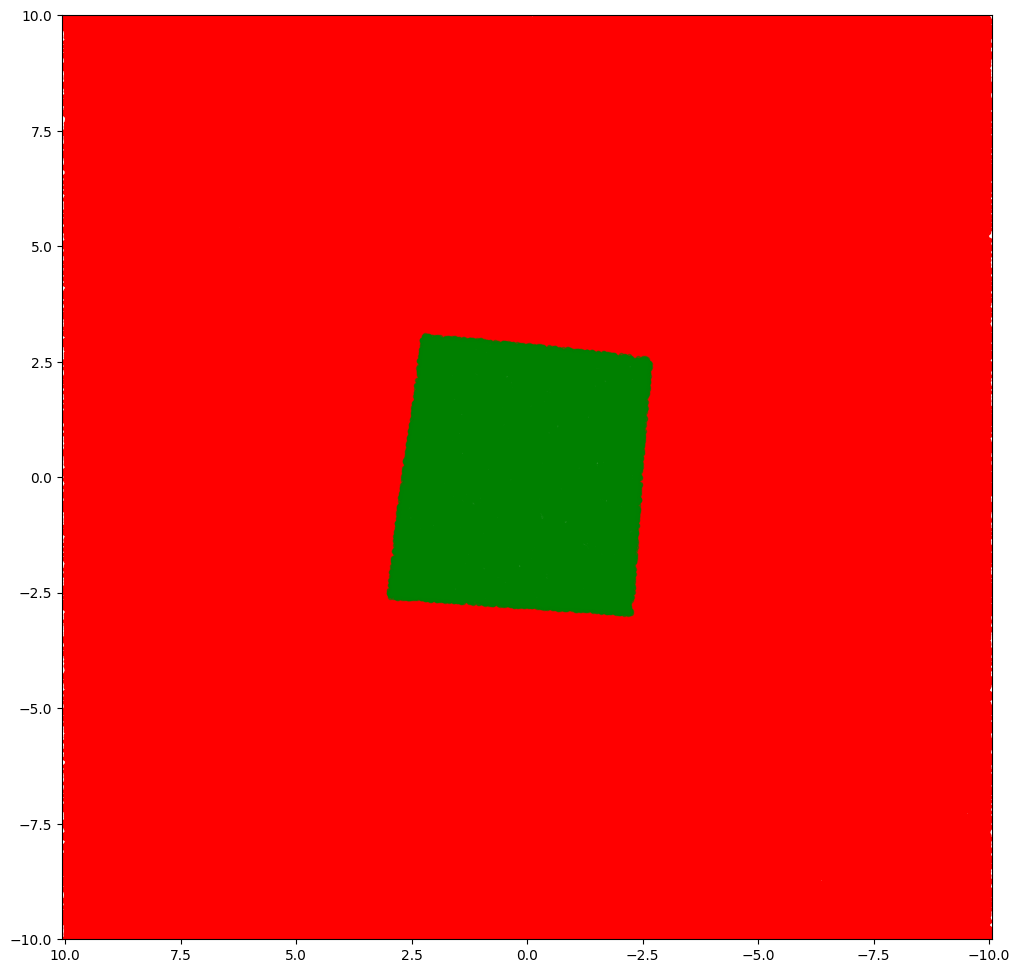

In [ ]:
# --------------------------------------------------------
# ------------------ Tracking (test 1) -------------------
# --------------------------------------------------------
#
# As a first test, we just track 5 turns.
# We expect to see the transversal profile generated by
# the three primaries opened at 5 sigma.


# Create initial particles
n_sigmas = 10
n_part = 500000
x_norm = np.random.uniform(-n_sigmas, n_sigmas, n_part)
y_norm = np.random.uniform(-n_sigmas, n_sigmas, n_part)
px_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
py_norm = np.random.uniform(-n_sigmas/10, n_sigmas/10, n_part)
part = xp.build_particles(tracker=line['b1'].tracker, x_norm=x_norm, y_norm=y_norm,#px_norm=px_norm, py_norm=py_norm,
                          scale_with_transverse_norm_emitt=(3.5e-6, 3.5e-6),
                          at_element='tcp.d6l7.b1',
                          #match_at_s=coll_manager.s_match['tcp.d6l7.b1']
                         )

# Track
print("Tracking first test.. ")
line['b1'].track(part, num_turns=5)

# The survival flags are sorted as surviving particles first,
# hence we need to 'unsort' them using their IDs
surv = part.state.copy()
surv[part.particle_id] = part.state

# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red')
plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green',alpha=0.5)
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
# plt.axis([2.5, -2.5, -2.5, 2.5])
plt.show()



In [ ]:
line.build_tracker()
# line.tracker

AssertionError: The line already has an associated tracker

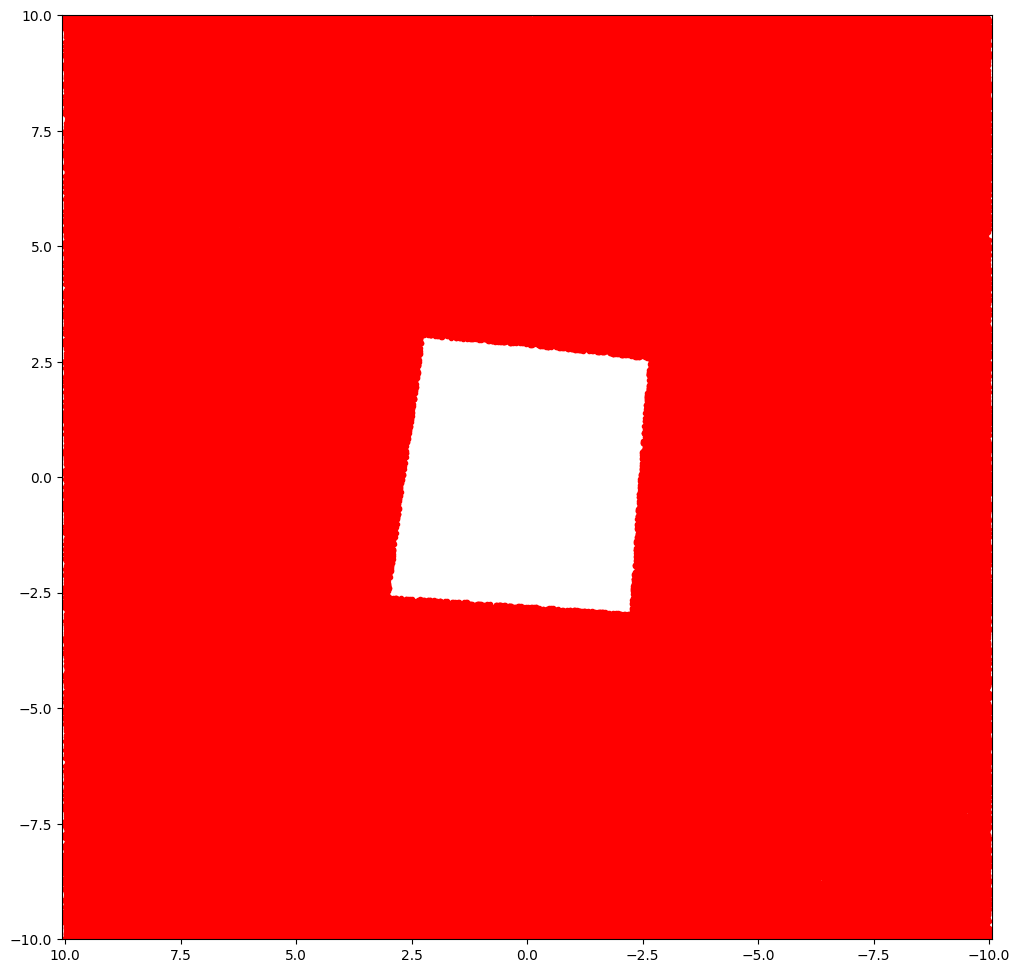

In [ ]:
# Plot the surviving particles as green
plt.figure(1,figsize=(12,12))
plt.plot(x_norm[surv<=0], y_norm[surv<=0], '.', color='red',alpha=1)
# plt.plot(x_norm[surv>0], y_norm[surv>0], '.', color='green')
plt.axis('equal')
plt.axis([n_sigmas, -n_sigmas, -n_sigmas, n_sigmas])
plt.show()

In [ ]:
np.sqrt(twiss['b1'].loc['tcp.d6l7.b1'].bety*3.5e-6/6500)/1e-3 * 10

1.9963169538788943

In [ ]:
line['b1'].check_aperture()

KeyboardInterrupt: 

In [ ]:
[ee for ee in list(line['b1'].element_names) if 'tcp' in ee]

['tcp.d6l7.b1',
 'tcp.c6l7.b1',
 'tcp.b6l7.b1',
 'tcpcv.a6l7.b1_aper',
 'tcpcv.a6l7.b1',
 'tcpch.a4l7.b1_aper',
 'tcpch.a4l7.b1',
 'tcp.6l3.b1']

In [ ]:
line['b1'].elements[line['b1'].element_names.index('tcpcv.a6l7.b1_aper')]

AttributeError: 'Drift' object has no attribute 'aperture'

27221

In [ ]:
line['b1'].elements['tcpcv.a6l7.b1_aper']

TypeError: tuple indices must be integers or slices, not str

In [ ]:
line['b1'].elements[list(tcp_apertures.keys())[1]]

TypeError: tuple indices must be integers or slices, not str

In [ ]:
[nn for nn in line['b1'].element_names if '_aper' in nn]

['tcpcv.a6l7.b1_aper', 'tcpch.a4l7.b1_aper']

In [ ]:
twiss

{'b1':                        s             x            px             y  \
 name                                                                 
 ip3               0.0000 -1.155255e-07 -4.766949e-09  1.757476e-07   
 drift_0           0.0000 -1.155255e-07 -4.766949e-09  1.757476e-07   
 mcbwv.4r3.b1     21.0300 -2.157744e-07 -4.766949e-09  2.308550e-07   
 drift_1          21.0300 -2.157744e-07 -4.766949e-09  2.308550e-07   
 bpmw.4r3.b1      22.5205 -2.228795e-07 -4.766949e-09  2.347607e-07   
 ...                  ...           ...           ...           ...   
 drift_30723   26636.4387 -8.533768e-09 -4.766949e-09  1.169338e-07   
 mcbwh.4l3.b1  26640.1832 -2.638360e-08 -4.766949e-09  1.267459e-07   
 drift_30724   26640.1832 -2.638360e-08 -4.766949e-09  1.267459e-07   
 lhcb1ip3_p_   26658.8832 -1.155255e-07 -4.766949e-09  1.757476e-07   
 _end_point    26658.8832 -1.155255e-07 -4.766949e-09  1.757476e-07   
 
                         py          zeta         delta          ptau

In [ ]:
line = xt.Line.from_json(LINEFOLDER + f'line_opticsfile32_{seq}.json')

Done loading line from dict.           


In [ ]:
line.particle_ref

In [ ]:
line_test = xPlus.importLine(LINEFOLDER + f'line_opticsfile32_{seq}.json')

Done loading line from dict.           


In [ ]:
line_test.particle_ref

Particles(_capacity=1, _num_active_particles=1, _num_lost_particles=0, start_tracking_at_element=-1, q0=1.0, mass0=938272088.16, _p0c=[6.79999994e+12], _gamma0=[7247.36468857], _beta0=[0.99999999], s=[0.], zeta=[1.02733591e-07], _ptau=[4.52392643e-07], _delta=[4.52392647e-07], _rpp=[0.99999955], _rvv=[1.], chi=[1.], charge_ratio=[1.], weight=[1.], particle_id=[0], at_element=[0], at_turn=[0], state=[1], parent_particle_id=[0], _rng_s1=[0], _rng_s2=[0], _rng_s3=[0], _rng_s4=[0], x=[-1.15452677e-07], y=[1.75657612e-07], px=[-4.76933733e-09], py=[2.61995815e-09])

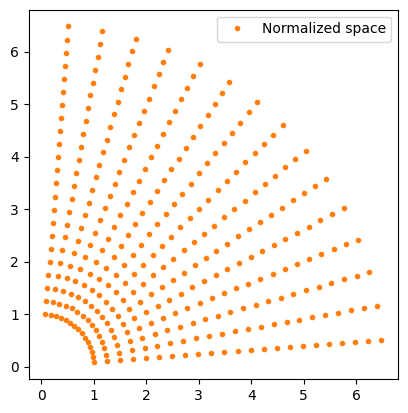

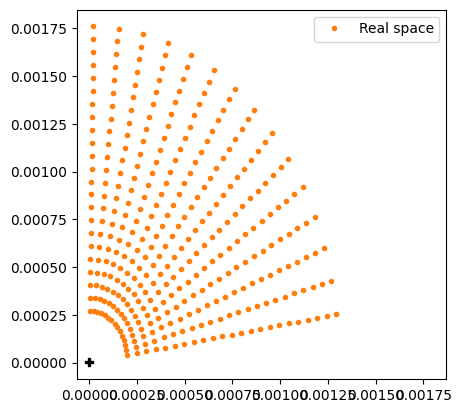

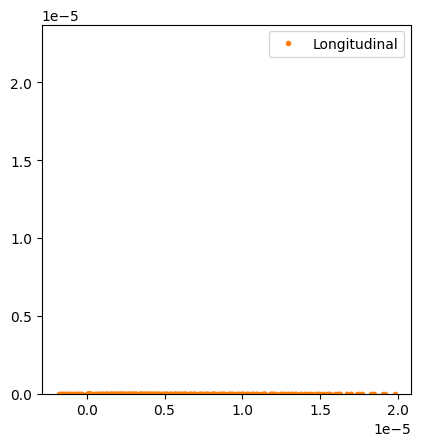

In [ ]:


def generate_particles():
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.linspace(1,6.5,23),
                                    theta_sig = np.linspace(0.05*np.pi/2,0.95*np.pi/2,15),
                                    emitt     = [B1.emittx,B1.emitty])
    coordinates.insert(0,'delta',0)
    group_length = len(coordinates)

    #coordinates = pd.concat([coordinates,coordinates,coordinates],ignore_index=True)
    #coordinates.loc[group_length:2*group_length,'delta'] = 0.55e-4#2.5e-9*tracker.line.particle_ref.beta0[0]*cst.c
    #coordinates.loc[2*group_length:,'delta']             = 1.10e-4#2.5e-9*tracker.line.particle_ref.beta0[0]*cst.c



    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [B1.emittx_n,B1.emitty_n])
    
    return particles,coordinates



particles,coordinates = generate_particles()


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.',color='C1',label='Normalized space')
plt.axis('square')
plt.legend()


_tmp_twiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
_tmp_twiss.set_index('name',inplace=True)
plt.figure()
plt.plot(particles.x   ,particles.y    ,'.',color='C1',label='Real space')
plt.plot(_tmp_twiss.loc['ip3','x'],_tmp_twiss.loc['ip3','y'],'P',color='k')
plt.axis('square')
plt.legend()


plt.figure()
plt.plot(particles.zeta   ,particles.delta    ,'.',color='C1',label='Longitudinal')
plt.axis('square')
plt.legend()



---

# Tracking

In [ ]:


# Matching
#===================================
for _ip in ['ip1','ip5','ip2','ip8']:
    tracker.vars[f'{_ip}_bblr_ON'] = 0
    tracker.vars[f'{_ip}_bbho_ON'] = 0

tracker.vars['all_oct_ON']   = 1
tracker.vars['all_sext_ON']  = 1
tracker.match(vary=['dqx.b1','dqy.b1'], 
    targets = [
        ('qx', 62.31),
        ('qy', 60.32)])
tracker.match(vary=['dqpx.b1_sq','dqpy.b1_sq'],
    targets = [
        ('dqx', 15.0),
        ('dqy', 15.0)])

tw_final = tracker.twiss()
Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
print('\nFinal twiss parameters')
print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
      f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
#===================================



Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00000 Q'y = 15.00000


In [ ]:


# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 0
tracker.vars[f'ip5_bbho_ON'] = 0

tracker.vars[f'ip1_bblr_ON'] = 0
tracker.vars[f'ip5_bblr_ON'] = 0

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================

particles,coordinates = generate_particles()
tracked_ref = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)




# Choosing knobs
#==========================
tracker.vars[f'ip1_bbho_ON'] = 1/10
tracker.vars[f'ip5_bbho_ON'] = 1/10

tracker.vars[f'ip1_bblr_ON'] = 1/10
tracker.vars[f'ip5_bblr_ON'] = 1/10

tracker.vars['all_oct_ON']   = 0
tracker.vars['all_sext_ON']  = 1
#==========================


particles,coordinates = generate_particles()
tracked = xPlus.Tracking(tracker, particles, n_turns = 1024,progress=True)


# Try zeroing longitudinal
#particles.zeta *= 0
#particles.delta *= 0

#trackTwiss = pd.DataFrame(tracker.twiss(),columns = df_columns)
#trackTwiss.set_index('name',inplace=True)





Output()

generating ./4a2018bb4e24405d927a30815a84d3ed.c
the current directory is '/home/phbelang/abp/BBStudies/Examples'
running build_ext
building '4a2018bb4e24405d927a30815a84d3ed' extension
gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /home/phbelang/abp/BBStudies/Executables/miniconda/include -fPIC -I/home/phbelang/abp/BBStudies/Executables/py_BB/include -I/home/phbelang/abp/BBStudies/Executables/miniconda/include/python3.9 -c 4a2018bb4e24405d927a30815a84d3ed.c -o ./4a2018bb4e24405d927a30815a84d3ed.o -std=c99 -O3 -Wno-unused-function


gcc -pthread -B /home/phbelang/abp/BBStudies/Executables/miniconda/compiler_compat -shared -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -Wl,-rpath-link,/home/phbelang/abp/BBStudies/Executables/miniconda/lib -L/home/phbelang/abp/BBStudies/Executables/miniconda/lib ./4a2018bb4e24405d927a30815a84d3ed.o -o ./4a2018bb4e24405d927a30815a84d3ed.cpython-39-x86_64-linux-gnu.so -std=c99 -O3


Output()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


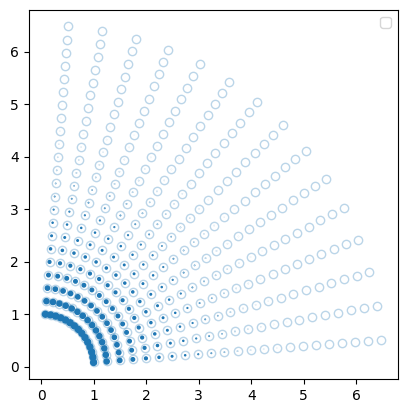

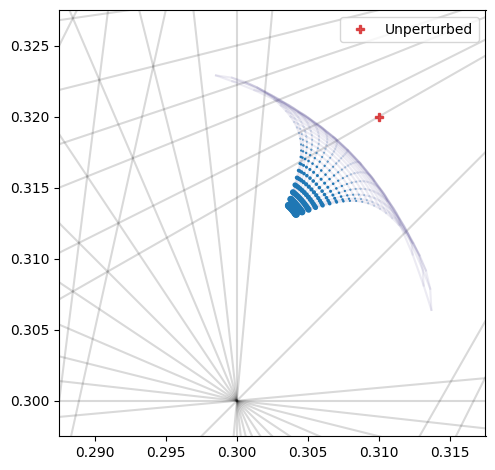

In [ ]:
import scipy.stats as sciStat


plt.figure()
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o',color='C0',mfc='none',alpha=0.3)
plt.scatter(coordinates['x_sig'],coordinates['y_sig'],s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0))
plt.axis('square')
plt.legend()
plt.savefig('footprint_coordinates.png',format='png',dpi=300)

window    = 0.03
Qx_0,Qy_0 = 0.31, 0.32
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]

# Plotting



# ALL PARTICLES
chosen_particles = (coordinates['r_sig']>0)

Qx_tot = np.zeros(len(coordinates[chosen_particles]))+ Qx_0
Qy_tot = np.zeros(len(coordinates[chosen_particles]))+ Qy_0
plt.figure()

# orders = list(np.arange(12)+1)[::-1]
# lws    = np.linspace(1,8,len(orders))
# alphas = np.linspace(0.01,0.6,len(orders))

# for order,lw,alpha in zip(orders,lws,alphas):
#     bbplt.workingDiagram(Qx_range=Qx_lim,Qy_range=Qy_lim,order=[order],color='k',lw=lw, alpha=alpha)
#---------------
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

Qx = Qx_0 + dQx*10
Qy = Qy_0 + dQy*10
#---------------

bbplt.polarmesh(Qx,Qy,alpha=0.1,r=coordinates[chosen_particles]['r_sig'],theta=coordinates[chosen_particles]['theta_sig'],color='darkslateblue')
plt.scatter(Qx,Qy,s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()
plt.savefig('footprint_all_scaled.png',format='png',dpi=300)


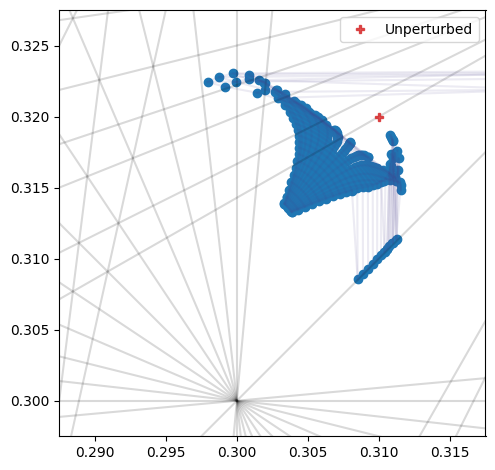

In [ ]:
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)
#---------------
tracked._tunesMTD     = 'nafflib'
tracked_ref._tunesMTD = 'nafflib'
dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

Qx = Qx_0 + dQx
Qy = Qy_0 + dQy
#---------------

bbplt.polarmesh(Qx,Qy,alpha=0.1,r=coordinates[chosen_particles]['r_sig'],theta=coordinates[chosen_particles]['theta_sig'],color='darkslateblue')
plt.scatter(Qx,Qy)#s = 30*sciStat.norm.pdf(coordinates['r_sig'])/sciStat.norm.pdf(0),zorder=10)
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.tight_layout()

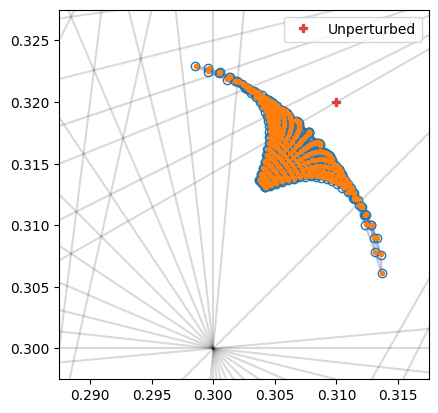

In [ ]:
window    = 0.03
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]


for tracked in [tracked_HO]:

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'o',mfc='none')

    tracked._tunesMTD     = 'nafflib'
    tracked_ref._tunesMTD = 'nafflib'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    plt.plot(Qx,Qy,'.')
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('square')
    plt.xlim(Qx_lim)
    plt.ylim(Qy_lim)
    plt.savefig(f'tmp_fig/footprint_HO.png',format='png')


for idx,tracked in enumerate(tracking_results[::-1]):

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'o',mfc='none')

    tracked._tunesMTD     = 'nafflib'
    tracked_ref._tunesMTD = 'nafflib'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    plt.plot(Qx,Qy,'.')
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('equal')
    plt.xlim([0.308,0.312])
    plt.ylim([0.318,0.322])
    plt.savefig(f'tmp_fig/footprint_lr_{str(idx).zfill(2)}.png',format='png')


plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results + [tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'o',mfc='none')

tracked._tunesMTD     = 'nafflib'
tracked_ref._tunesMTD = 'nafflib'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results+[tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
plt.plot(Qx_tot,Qy_tot,'.')
plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.savefig(f'tmp_fig/footprint_TOTAL.png',format='png')

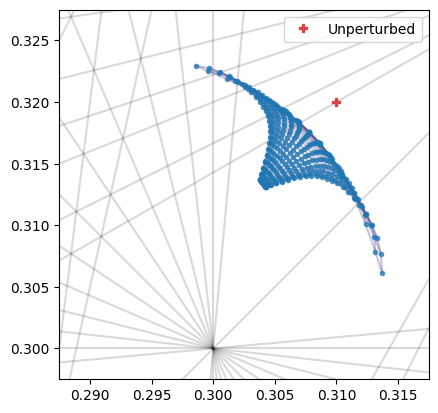

In [ ]:
window    = 0.03
Qx_lim    = [Qx_0-3*window/4,Qx_0+window/4]
Qy_lim    = [Qy_0-3*window/4,Qy_0+window/4]


for tracked in [tracked_HO]:

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'.',alpha=0.7)
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('square')
    plt.xlim(Qx_lim)
    plt.ylim(Qy_lim)
    plt.savefig(f'tmp_fig2/footprint_HO.png',format='png')


for idx,tracked in enumerate(tracking_results[::-1]):

    plt.close('all')
    plt.figure()
    bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)


    tracked._tunesMTD     = 'pynaff'
    tracked_ref._tunesMTD = 'pynaff'
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']

    Qx = Qx_0 + dQx
    Qy = Qy_0 + dQy
    bbplt.polarmesh(Qx,Qy,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
    plt.plot(Qx,Qy,'.',alpha=0.7)
    

    plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')
    plt.legend()
    plt.axis('equal')
    plt.xlim([0.308,0.312])
    plt.ylim([0.318,0.322])
    plt.savefig(f'tmp_fig2/footprint_lr_{str(idx).zfill(2)}.png',format='png')


plt.close('all')
plt.figure()
bbplt.workingDiagram(order=12,Qx_range=Qx_lim,Qy_range = Qy_lim,alpha=0.15)

tracked._tunesMTD     = 'pynaff'
tracked_ref._tunesMTD = 'pynaff'
Qx_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qx_0
Qy_tot = np.zeros(len(tracked.tunes_n['Qx']))+ Qy_0
for idx,tracked in enumerate(tracking_results + [tracked_HO]):
    dQx = tracked.tunes_n['Qx'] - tracked_ref.tunes_n['Qx']
    dQy = tracked.tunes_n['Qy'] - tracked_ref.tunes_n['Qy']
    Qx_tot += dQx
    Qy_tot += dQy
bbplt.polarmesh(Qx_tot,Qy_tot,r=coordinates['r_sig'],theta=coordinates['theta_sig'],color='darkslateblue')
plt.plot(Qx_tot,Qy_tot,'.',alpha=0.7)

plt.plot(Qx_0,Qy_0,'P',color='C3',alpha=0.8,label='Unperturbed')

plt.legend(loc='upper right')
plt.axis('square')
plt.xlim(Qx_lim)
plt.ylim(Qy_lim)
plt.savefig(f'tmp_fig2/footprint_TOTAL.png',format='png')

In [ ]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/BBStudies/Executables/py_BB/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


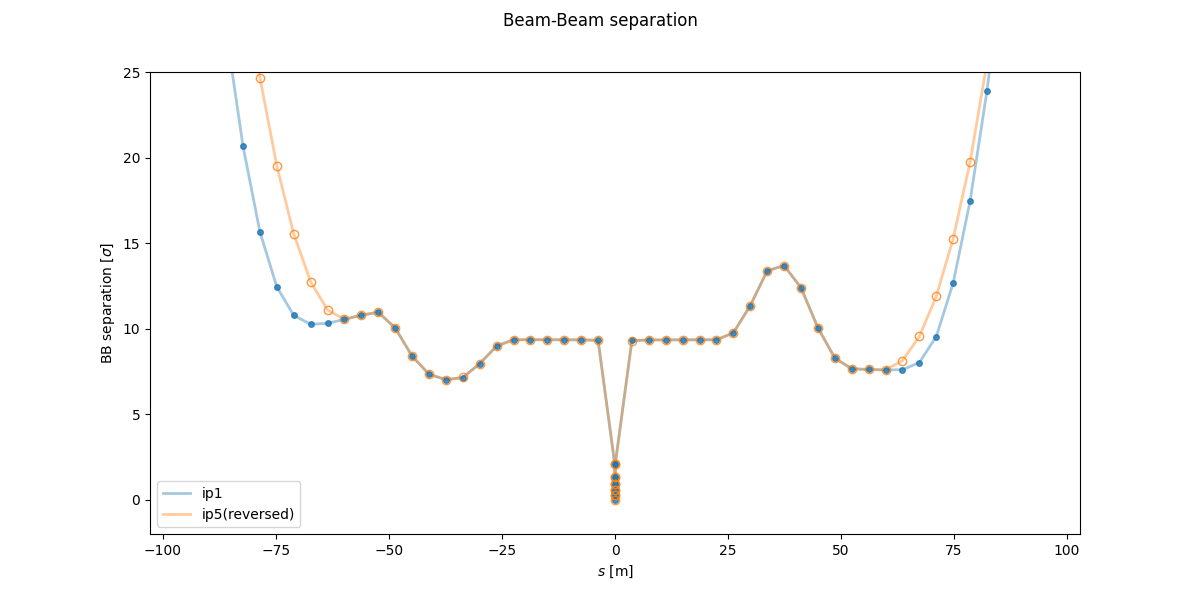

In [ ]:
fig = plt.figure(figsize=(12,6))
fig.suptitle(f'Beam-Beam separation')

for _IP in [IP1,IP5]:
    
    # Plotting   
   
    dx_n_tot = np.sqrt(_IP.bb['dx_n']**2 + _IP.bb['dy_n']**2)
    if _IP.name == 'ip1':
        plt.plot(_IP.bb['s'],dx_n_tot,'-',color='C0',alpha=0.4,lw=2,label=_IP.name,zorder=-10)
        plt.plot(_IP.bb['s'],dx_n_tot,ls='' ,color='C0',alpha=0.8,marker='.',ms=8)
    else:
        plt.plot(-_IP.bb['s'],dx_n_tot,'-',color='C1',alpha=0.4,lw=2,label=_IP.name + '(reversed)',zorder=-9)
        plt.plot(-_IP.bb['s'],dx_n_tot,ls='' ,color='C1',alpha=0.8,marker='.',mfc='none',ms=12)
    plt.legend()
    
    plt.xlabel(r'$s$ [m]')
    plt.ylabel(r'BB separation [$\sigma$]')
    
    plt.ylim([-2,25])